# Stabilizing the Cart-Pole system

In this exercise, we will use LQR to stabilize a cart-pole system and then adapt the LQR controller to get the robot to move along a specified path.

<img src="cart_pole.png" alt="drawing" width="400"/>

The difficulty of the cart-pole system is that we can only move the cart back and forth (using $u$) to move both the cart and the pendulum. Therefore, it is not trivial to find a good controller to get the pendulum to stay balanced on top of the cart while moving the cart around. We will see how we can use our optimal control approach to do such things.

In [1]:
# setup matplotlib for nice display in Jupyter
%matplotlib notebook

# a few libraries we will need
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import matplotlib.animation as animation

import IPython

np.set_printoptions(precision=5,linewidth=120,suppress=True)

#import linear_oc_tools as oc

## The cart-pole model

The dynamics of the cart-pole can be written as
\begin{align} 
\dot{x} &= v\\
\dot{\theta} &= \omega\\
\dot{v} &= \frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta} \\
 \dot{\omega} &= \frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\end{align}
 
There are four states: the position $x$ and linear velocity $v$ of the cart, the angle of the pendulum $\theta$ and its angular velocity $\omega$. There is one control input $u$ which is the force applied on the cart. We will write $z = \begin{bmatrix} x & \theta & v & \omega \end{bmatrix}^T$ the state vector.

We know that the point where the pendulum is vertical is an unstable fixed point of the system. We would like to stabilize the fixed point $\bar{z} = \begin{bmatrix} \bar{x} & \bar{\theta} & \bar{v} & \bar{\omega} \end{bmatrix}^T = \begin{bmatrix} 0 & \pi & 0 & 0 \end{bmatrix}^T$.

Like most robotic systems, it is not linear. It is also underactuated, i.e. we have only one control input to control two degrees of freedom.

We will first linearize the system around $\bar{z}$ (with $\bar{u}=0$) and then compute a LQR control law to stabilize it. The control law will be approximately optimal for the nonlinear system but should be a good enough approximation when sufficiently close to the fixed point.

## Linearizing the dynamics
We linearize $\dot{z} = f(z,u) \simeq f(\bar{z},\bar{u}) + \frac{\partial f}{\partial z}_{|z=\bar{z}, u=\bar{u}} (z - \bar{z}) + \frac{\partial f}{\partial u}_{|z=\bar{z}, u=\bar{u}}(u - \bar{u})$.

We have $f(\bar{z},\bar{u}) = 0$. 

Next, we compute the partial derivatives of the dynamics with respect to all state and control variables.

For the first two equations, this is straightforward:
\begin{equation}\frac{\partial}{\partial x} v = 0,\ \frac{\partial}{\partial \theta} v = 0, \ \frac{\partial}{\partial v} v = 1,\ \frac{\partial}{\partial \omega} v = 0\end{equation}
\begin{equation}\frac{\partial}{\partial x} \omega = 0,\ \frac{\partial}{\partial \theta} \omega = 0, \ \frac{\partial}{\partial v} \omega = 0,\ \frac{\partial}{\partial \omega} \omega = 1\end{equation}

For the third equation:
$$\frac{\partial}{\partial x} \left(\frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta} \right) = 0$$
$$\frac{\partial}{\partial \theta} \left(\frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta}\right) = \frac{(m_p\cos\theta(l \omega^2 + g \cos\theta) - m_pg\sin^2\theta)(m_c  + m_p \sin^2 \theta) - (u + m_p \sin\theta (l \omega^2 + g \cos\theta)) (2m_p \sin\theta\cos\theta) }{(m_c  + m_p \sin^2 \theta)^2}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives $$\frac{m_p g}{m_c}$$
Now for the linear velocity
$$\frac{\partial}{\partial v} \left(\frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta}\right) = 0$$
and for the angular velocity
$$\frac{\partial}{\partial \omega} \left(\frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta}\right) = \frac{2m_p \sin\theta l \omega}{m_c  + m_p \sin^2 \theta}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives 0

Finally we have
$$\frac{\partial}{\partial x} \left(\frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\right) = 0$$
$$\frac{\partial}{\partial \theta} \left(\frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\right) = \frac{(u\sin\theta - m_p l \omega^2 (\cos^2\theta - \sin^2 \theta) - (m_c + m_p)g\cos\theta) (l(m_c  + m_p \sin^2 \theta)) - (-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta)(2l m_p \sin\theta\cos\theta)}{(l(m_c  + m_p \sin^2 \theta))^2}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives $$\frac{(m_p + m_c) g}{lm_c}$$
For the linear velocity
$$\frac{\partial}{\partial v} \left(\frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\right) = 0$$
and finally
$$\frac{\partial}{\partial \omega} \left(\frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\right) = \frac{- 2m_p l \omega\cos\theta \sin\theta}{l(m_c  + m_p \sin^2 \theta)}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives 0.

We now compute the partial derivatives with respect to the control command. We have
$$\frac{\partial}{\partial u} v = 0$$
$$\frac{\partial}{\partial u} \omega = 0$$
$$\frac{\partial}{\partial u} \left(\frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta}\right) = \frac{1}{m_c  + m_p \sin^2 \theta}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives $$\frac{1}{m_c}$$
and the last one
$$\frac{\partial}{\partial u} \left(\frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\right) = \frac{-\cos\theta}{l(m_c  + m_p \sin^2 \theta)}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives $$\frac{1}{lm_c}$$

We can gather all these terms and get the linearized dynamics
$$\dot{z} = \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & \frac{m_p g}{m_c} & 0 & 0 \\ 0 & \frac{(m_p + m_c) g}{lm_c} & 0 & 0 \end{bmatrix} (z - \bar{z}) + \begin{bmatrix} 0 \\ 0 \\ \frac{1}{m_c} \\ \frac{1}{lm_c} \end{bmatrix} (u-\bar{u})$$

Finally, we change coordinates to center around the linearized point, we set $\tilde{z} = z - \bar{z}$ and $\tilde{u} = u-\bar{u}$ and get the following dynamics
$$\dot{\tilde{z}} = \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & \frac{m_p g}{m_c} & 0 & 0 \\ 0 & \frac{(m_p + m_c) g}{lm_c} & 0 & 0 \end{bmatrix} \tilde{z} + \begin{bmatrix} 0 \\ 0 \\ \frac{1}{m_c} \\ \frac{1}{lm_c} \end{bmatrix} \tilde{u}$$


## Discretizing the dynamics
We now discretize the dynamics, using $\Delta t$ for the integration step. We have 
$$\tilde{z}_{n+1} = \tilde{z}_n + \Delta t \left( \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & \frac{m_p g}{m_c} & 0 & 0 \\ 0 & \frac{(m_p + m_c) g}{lm_c} & 0 & 0 \end{bmatrix} \tilde{z}_n + \begin{bmatrix} 0 \\ 0 \\ \frac{1}{m_c} \\ \frac{1}{lm_c} \end{bmatrix} \tilde{u}_n \right)$$
or equivalently
$$\tilde{z}_{n+1} =  \begin{bmatrix} 1 & 0 & \Delta t & 0 \\ 0 & 1 & 0 & \Delta t \\ 0 & \Delta t\frac{m_p g}{m_c} & 1 & 0 \\ 0 & \Delta t\frac{(m_p + m_c) g}{lm_c} & 0 & 1 \end{bmatrix} \tilde{z}_n + \begin{bmatrix} 0 \\ 0 \\ \frac{\Delta t}{m_c} \\ \frac{\Delta t}{lm_c} \end{bmatrix} \tilde{u}_n $$

We now have an approximation of the dynamics in a form that can be used to compute linear optimal controllers (i.e. LQR). The controllers we will compute will be of the form $$ \tilde{u}_n = K_n \tilde{z}_n + k_n$$
and they will need to be transformed into
$$ u_n = K_n (z_n - \bar{z}) + k_n$$
to be used on the original system.

## Simulating the cart pole system with arbitrary controllers

Below are a few helper functions to simulate the cart-pole system and display its behavior

In [2]:
class CartPole:
    """
    This class describes a cart pole model and provides some helper functions
    """
    
    def __init__(self):
        """
        constructor of the class, takes as input desired discretization number
        for x (angle), v (angular velocity) and u (control) and the maximum control
        """
        #store discretization information
        self.road_length = 3.
        
        #gravity constant
        self.g=9.81

        #integration step
        self.dt = 0.01
        
        #we define lengths and masses
        self.l = 1.0
        self.mc = 5.0
        self.mp = 1.0
            
    def next_state(self,z,u):
        """
        Inputs:
        z: state of the cart pole syste as a numpy array (x,theta,v,omega)
        u: control as a scalar number
        
        Output:
        the new state of the pendulum as a numpy array
        """
        x = z[0]
        th = z[1]
        v = z[2]
        om = z[3]
        x_next = (x + self.dt * v)
        th_next = (th + self.dt * om)
        v_next = v + self.dt*((u + self.mp*np.sin(th)*(self.l*om**2 + self.g * np.cos(th)))/(self.mc+self.mp*np.sin(th)**2))
        w_next = om + self.dt*((-u*np.cos(th)-self.mp*self.l*(om**2)*np.cos(th)*np.sin(th)-(self.mc+self.mp)*self.g*np.sin(th))/(self.mc+self.mp*np.sin(th)**2))
        z = np.array([x_next,th_next,v_next,w_next])
        return z
    
    def simulate(self, z0, controller, horizon_length):
        """
        This function simulates the pendulum of horizon_length steps from initial state x0
        
        Inputs:
        z0: the initial conditions of the pendulum as a numpy array (x,theta,v,omega)
        controller: a function that takes a state z as argument and index i of the time step and returns a control u
        horizon_length: the horizon length
        
        Output:
        z[4xtime_horizon+1] and u[1,time_horizon] containing the time evolution of states and control
        """
        z=np.empty([4, horizon_length+1])
        z[:,0] = z0
        u=np.empty([1,horizon_length])
        for i in range(horizon_length):
            u[:,i] = controller(z[:,i],i)
            z[:,i+1] = self.next_state(z[:,i], u[:,i])
        return z, u
    
    def LQR_simulate(self, z0, control_collect, controller, horizon_length):
        """
        This function simulates the pendulum of horizon_length steps from initial state x0 with LQR control
        
        Inputs:  
        z0: the initial conditions of the pendulum as a numpy array (x,theta,v,omega)
        control_collect: a collction of control generated by sovling Riccati equation w.r.t the horizon
        controller: a function that takes a state z as argument and index i of the time step and returns a control u
        horizon_length: the horizon length
        
        Output:
        z[4xtime_horizon+1] and u[1,time_horizon] containing the time evolution of states and control
        """
        z=np.empty([4, horizon_length+1])
        z[:,0] = z0
        u=np.empty([1,horizon_length])
        for i in range(horizon_length):
            K = control_collect[i]
            u[:,i] = controller(z[:,i],K,i)
            z[:,i+1] = self.next_state(z[:,i], u[:,i])
        return z, u
    
    def LQR_tra_simulate(self, z0, control_collect, controller, horizon_length):
        """
        This function simulates the pendulum of horizon_length steps from initial state x0 with LQR control for 
        tracking a desired state sequence
        Inputs:  
        z0: the initial conditions of the pendulum as a numpy array (x,theta,v,omega)
        control_collect: a collction of control (K,k) generated by sovling Riccati equation w.r.t the horizon
        controller: a function that takes a state z as argument and index i of the time step and returns a control u
        horizon_length: the horizon length
        
        Output:
        z[4xtime_horizon+1] and u[1,time_horizon] containing the time evolution of states and control
        """
        z=np.empty([4, horizon_length+1])
        z[:,0] = z0
        u=np.empty([1,horizon_length])
        for i in range(horizon_length):
            K = control_collect[0][i]
            k = control_collect[1][i]
            u[:,i] = controller(z[:,i],K,k,i)
            z[:,i+1] = self.next_state(z[:,i], u[:,i])
        return z, u

In [3]:
def animate_cart_pole(x, dt):
    """
    This function makes an animation showing the behavior of the cart-pole
    takes as input the result of a simulation (with dt=0.01s)
    """
    
    min_dt = 0.1
    if(dt < min_dt):
        steps = int(min_dt/dt)
        use_dt = int(min_dt * 1000)
    else:
        steps = 1
        use_dt = int(dt * 1000)
    
    #what we need to plot
    plotx = x[:,::steps]
    
    fig = mp.figure.Figure(figsize=[8.5,2.4])
    mp.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-4.25,4.25], ylim=[-1.,1.4])
    ax.grid()
    
    list_of_lines = []
    
    #create the cart pole
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    
    cart_length = 0.5
    cart_height = 0.25
    
    def animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        
        x_back = plotx[0,i] - cart_length
        x_front = plotx[0,i] + cart_length
        y_up = cart_height
        y_down = 0.
        x_pend = plotx[0,i] + np.sin(plotx[1,i])
        y_pend = cart_height - np.cos(plotx[1,i])
        
        list_of_lines[0].set_data([x_back, x_front], [y_down, y_down])
        list_of_lines[1].set_data([x_front, x_front], [y_down, y_up])
        list_of_lines[2].set_data([x_back, x_front], [y_up, y_up])
        list_of_lines[3].set_data([x_back, x_back], [y_down, y_up])
        list_of_lines[4].set_data([plotx[0,i], x_pend], [cart_height, y_pend])
        
        return list_of_lines
    
    def init():
        return animate(0)


    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:])),
        interval=use_dt, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

<IPython.core.display.Javascript object>


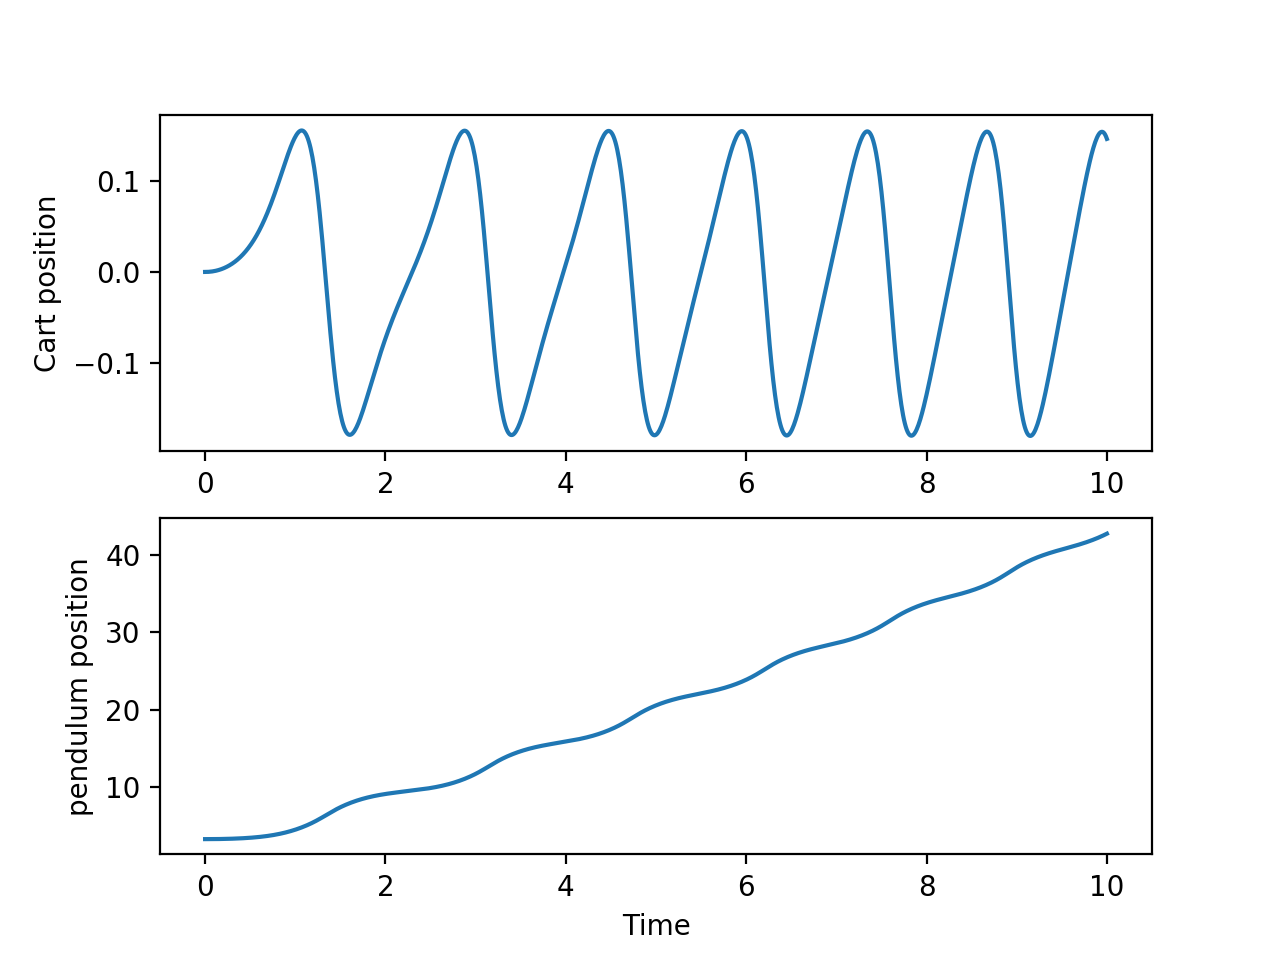

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAB/6G1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA9qZYiE
AD///vdonwKbWkN6gOSVxSXbT4H/q2dwfI/pAwAAAwAAAwAAAwAAdaFhgCmhz+EeJXEB8N6fIJ7J
rhIV+NN9XHf+yK6HeTLxVohwsVcDo5RFQnt96ggNjzTuW/beQ9Ceg3f9LFZ5ZPoaVjdmAKgN7/Gc
Kr0gtL00uCkVv1C53J99XsNJS/gMh9fGR78jKGqiLQYpnc7fg6Gpmja2JwPurpkXHfl1gpDCA/ni
GRiQrPLlt2OPB05Qm73KqD/tHmPdnwiciUPTyOfO6Zk07JaciEI6Yzb1U3ur4ZDCUntx2SEy8nWx
NJ2p4hAZhmqmaecLjIeScUwnm9E0sSwKPUt1k7A4B5UEP2CBebM5BrR5tzxy8gmROwXuQAIz+7KF
CZMhHJyr7MX0bYv6IL2gPlMmVpE2fPJPvcQdFvc4e1VYi8npFJIgHJFoOdXwSbcwhGs2NCBHE0ps
lk38ndaNzOFTeIKdkGveGqwyaPXaD2lorbo6wo8rTrcp1pUBbE3CDgfvEsITbxzm9cEDuFBQd/DN
dYwVbMtu3QoJiQxIwwE6nfRHbLbbZDfSkEGHYLO1+D79Y4ky8OACq69ErFhxOgQ2t6HS8CzDZl4V
GR0BSljLgpUTiRuHZ4ufORG1r2DaIA4MWeUUEJP4QD5GzZDnqd3X+P05doWNkmZlqseMzqeoomQW
U+k2QEaWVFOujeHDyzRoMJIs0PYy0Qp6+l7DVhk9VHhH4ItJUyUwlJul6h4hkDBo+2IMGxtCREWL
faA33QF+veNlr2uh6tlB/zT03Od19U0i/LEd/C4H9Oyil9u4kCrJsGFqfQUa75aczjs1aZgayPVc
pn6PKQzYrU7ol/XatGg34ksvDaB/mVIHXO2yERfFKl3PyUT/7ewOQ6/QK3jhVv4/oMuJNHXSV/zO
jEMoLTfMNzdU2P6stBmPq/xMz6Nq68lQxftAkrjlU/PGGIHsSFsK7ioHPyP6NPzV+cdxmVtPj9Lc
xvkZgHaEe1i4WzlFMmcJi2VPV1iOBh8cu0AAAHkWVtUUmzU1XiIC4afM/YoTj/+zDqOCSz9aUkR1
J9ptaXXOAvbwuVTM9iqWoLO950C/YCge90zo9wjF7VOxLk8BvoQvb0RLoVcbOq4B5hvpKwWuox1Z
QI6W0daAyMx+V93eLdfiUl3Xi1N4dJXdkzPbh67zhxYLEWGrV+tJNlHFRppEfK+ZdF7jOZa1pSAY
QGizCvxyw3Kct6CQD6R4BeqEoT2Py4IS9HCPqiOUcElUNQ4fh2nUxBbGe3RdEZFSMRNJnErPWkDt
lwLhytMLy+DrfvWWX9046xlp2/6aCgqNPQPKhDsMEgXxBEi5HA0QwsbyNiJteEiqF7/VWkes4pD2
LEp7aqJ1q7a379aSaEAAnUO1z8XokALTK4oPq/W+ryY3FEjThbwGLLURItFfnfcr1PHSow7EgDpA
/QB4JJ9AgGCr8AGUZlr8uItoi6D/FW/sYi6hXDCil3y9ZzsRzpgVIGCvLZ1Vvxwr2fcZNYHnLL//
pb0FFZhcdmraDBb9oPfFz1dfuudwKN4Elq0rvtVYbtL05GFojePIBbFqfBkgxyV3QvIf+zQiiVKe
ZBZ8TIrc/vdEy+vBPjL7g/7VDulP/5z5cdvi0uYB2YEOK6B42t0FVvabRQk95mQjICnG3uzwrpKS
Ehx4eFHIavVjVdMIVqVpa850SI+DwR1tnwi544m5viQTSXA+lARxfVbGM+SNqHfBalG6GEuGSKjU
ltVTBt0z461vclqCz7LQP7YmpSvVFZxkAQPbR76cEqQNjx0IgwdF7ZorzSiyDrSOzeNWFFoo+SIQ
FoYXCKc3ZjDgCnjAG20ATHWYiYPDgAY3JKRFtiwSRcIN1/42Ix0DJTLfkC/JnBIbJyK8M6tD2TGy
T/QPL1eHpJ60Kmom+RjbAKY6ygbAfn0y2xnQADLEke7ScUBdzGUKK+kaRHbse5LHcj2ILHItCx+7
hmuUf+kXhx+hfvYP1dgN5RhsCF8CTnBOEwEklCbi51vfTqkfPQKojOewH1TjYMTBxsAAACmofeYn
/2IWbI0S+lnfxTEDr/f49P6+OYm88RRLpf5h9uqWuDERNTFUIgQEy+s1ka2baTNGRisSwh09eb11
uZf6Xi8BlOTApMYV0Nolc1L911wGHBK4+b9x3pKin+U2hwJLCJoO2bWuMCZPwfWo/k296uFiW67w
HzO7JMwHNfTy6/W0zmUcogRyUIBb/lriWNDX9/oLC+F4EwcoLmoWxl5dpjE56xCCQJZAhhfXT6JX
/wkH+swUkfOyEQwPCQm0R/QVT0HFPE0a16V2ZEZ2/NfX54LoJQLIMBlXMCWpJunqEZ0O/SKq1AZ3
x/BiE6vZRMnRJFNUc04uvwqcw5aqP14ai6qdzyblin0Iys+9yMH78IUs7UMFz8I/g4LyYWjLlt0+
ek6usbCt7BBcM6YJHDVe888PhzeY+PDu5Yro24jlRNQOUxVszbs2Q5Ox5i5nTpvLMleufEsgxKEJ
RWx3ON54vKCbhXIVdLo8lGaEppx4aPqev8CzDmtrYFLrRLCkBUcoe7R3nhrHHSqK2lLAG1vJfKms
D3T11epvmip34TO7jEI3VJMq4zx+gw4i2h4Mz7VI7CeYACDm/7r/B9DSZ5Iruhj81IAB5Kc5+wp0
DVocflHn2Fe3O7tpj68MeJQfWOdj3z0MQx89nLRWHAeEI4xCfMYsn7U5b5k+/woRJGWND1KMQK+n
jyO07tD8txtaCmcgcvVjW5+/+SUdp6sGFOZmzijgIqn4u72+x2qT4Lz8jzjYWDpYjO8MlX3n0iVU
5HE59R5T3BMqqII5vfXZwjn4iOdxIkPLMa284skwMTTQpZ3vJTBLOw0O8P14AyZQWyYWCf9LX9aN
8ff1yHTJtKXs8GqaxXEnU

In [4]:
# we show an example on how to simulate the cartpole and display its behavior

# we create a cart pole
cart = CartPole()

# we create a controller that does nothing u(z) = 0
def useless_controller(z,i):
    return 0

# we simulate the cart pole and display its behavior
z0 = np.array([0,np.pi+0.1,0.,0])
horizon_length = 1000

z,u = cart.simulate(z0, useless_controller, horizon_length)
t = np.linspace(0,cart.dt*(horizon_length),horizon_length+1)
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,z[0,:])
plt.ylabel('Cart position')
plt.subplot(2,1,2)
plt.plot(t,z[1,:])
plt.ylabel('pendulum position')
plt.xlabel('Time')


animate_cart_pole(z, cart.dt)

# Question 1:
We would like to use the linearized equation to compute an optimal controller that stabilizes the system around the resting position.

1. Write a cost function that will help stabilize the resting position $\bar{z}$ (be precise with the variables you use).
2. Compute the infinite horizon gains to stabilize the cart pole system
3. Write a function that can stabilize the system and test the behavior of the robot using $z_0 = [0.5, \pi + 0.3, 0., 0.]^T$. Plot the time evolution of the control input and the states of the system.
4. What is the behavior of the system when starting with $z_0 = [0.5, 0.3, 0., 0.]^T$? Explain the behavior.

1. Our cost function is defined as follows, where $Q=200I$ and $R=2I$
$$\sum_{n=0}^\infty  (z_n-\bar{z})^T Q (z_n-\bar{z})+u_n^T R u_n$$

2. Let $\tilde{z}_n=z_n-\bar{z}$ and then the cost function becomes $$\sum_{n=0}^\infty  \tilde{z}_n^T Q\tilde{z}_n+u_n^T Ru_n$$ and the linear dynamics is given by
$$\tilde{z}_{n+1} =  \begin{bmatrix} 1 & 0 & \Delta t & 0 \\ 0 & 1 & 0 & \Delta t \\ 0 & \Delta t\frac{m_p g}{m_c} & 1 & 0 \\ 0 & \Delta t\frac{(m_p + m_c) g}{lm_c} & 0 & 1 \end{bmatrix} \tilde{z}_n + \begin{bmatrix} 0 \\ 0 \\ \frac{\Delta t}{m_c} \\ \frac{\Delta t}{lm_c} \end{bmatrix} \tilde{u}_n. $$ Notice that $\tilde{u}=u-\bar{u}$ and here $\bar{u}=0$, we have $\tilde{u}=u$.

In [5]:
# compute the linear control for infinite LQR
#A, B, Q, R are matrices involved; tol: tolerance; maxit: maximum iteration number
def inf_lqr(A,B,Q,R,tol,maxit):
    e=1
    dim1=np.size(A,1)
    dim2=np.size(B,1)
    #initialization
    K=np.zeros((dim2,dim1))
    P=np.eye(dim1)
    count=0
    while count<maxit:
        # ricatti equation
        P=Q+A.T.dot(P).dot(A)+A.T.dot(P).dot(B).dot(K)
        m=B.T.dot(P).dot(B)+R
        K1=-np.linalg.solve(m,B.T.dot(P).dot(A))
        e=np.linalg.norm(K1-K)
        # if the differnce is below the tol
        if e<tol:
            break
        count=count+1
        K=K1
    return K

In [6]:
# we create a cart pole
cart = CartPole()
#compute the gain K
Q=200*np.eye(4)
R=2
# construct the linear dynamics
A=np.eye(4)
A[0,2]=cart.dt
A[1,3]=cart.dt
A[2,1]=cart.dt*cart.mp*cart.g/cart.mc
A[3,1]=cart.dt*(cart.mp+cart.mc)*cart.g/(cart.l*cart.mc)
B=np.zeros((4,1))
B[2,0]=cart.dt/cart.mc
B[3,0]=cart.dt/(cart.l*cart.mc)
# compute the linear control using Ricatti equation
K=inf_lqr(A,B,Q,R,tol=1e-3,maxit=1000)
K

array([[   9.52577, -220.9336 ,   20.18574,  -67.9794 ]])

3. We use $K$ to stabilize the system and test the behavior of the robot using $z_0 = [0.5, \pi + 0.3, 0., 0.]^T$. We also plot the time evolution of the control input and the states of the system.

<IPython.core.display.Javascript object>


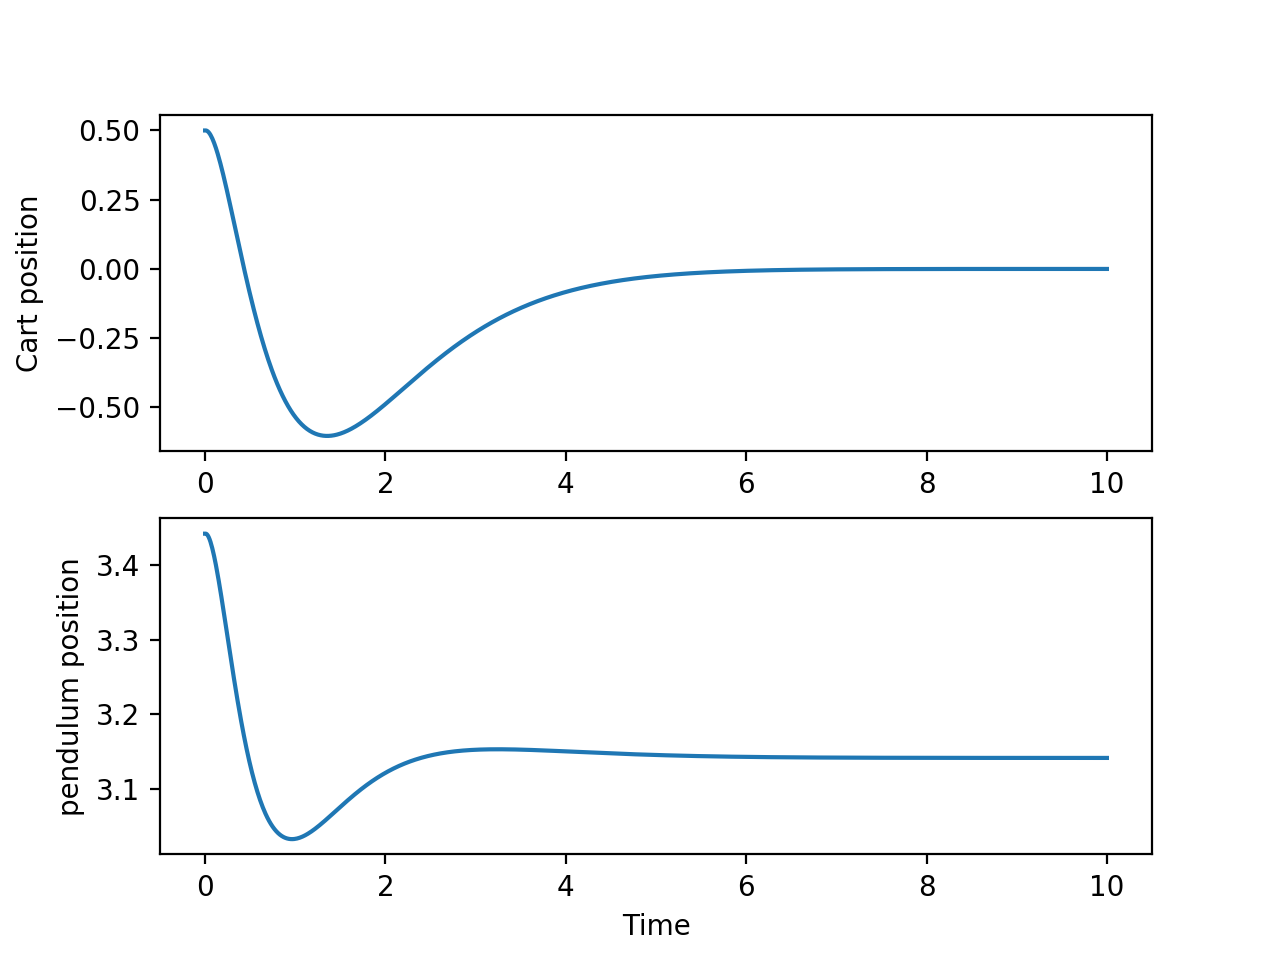

<IPython.core.display.Javascript object>


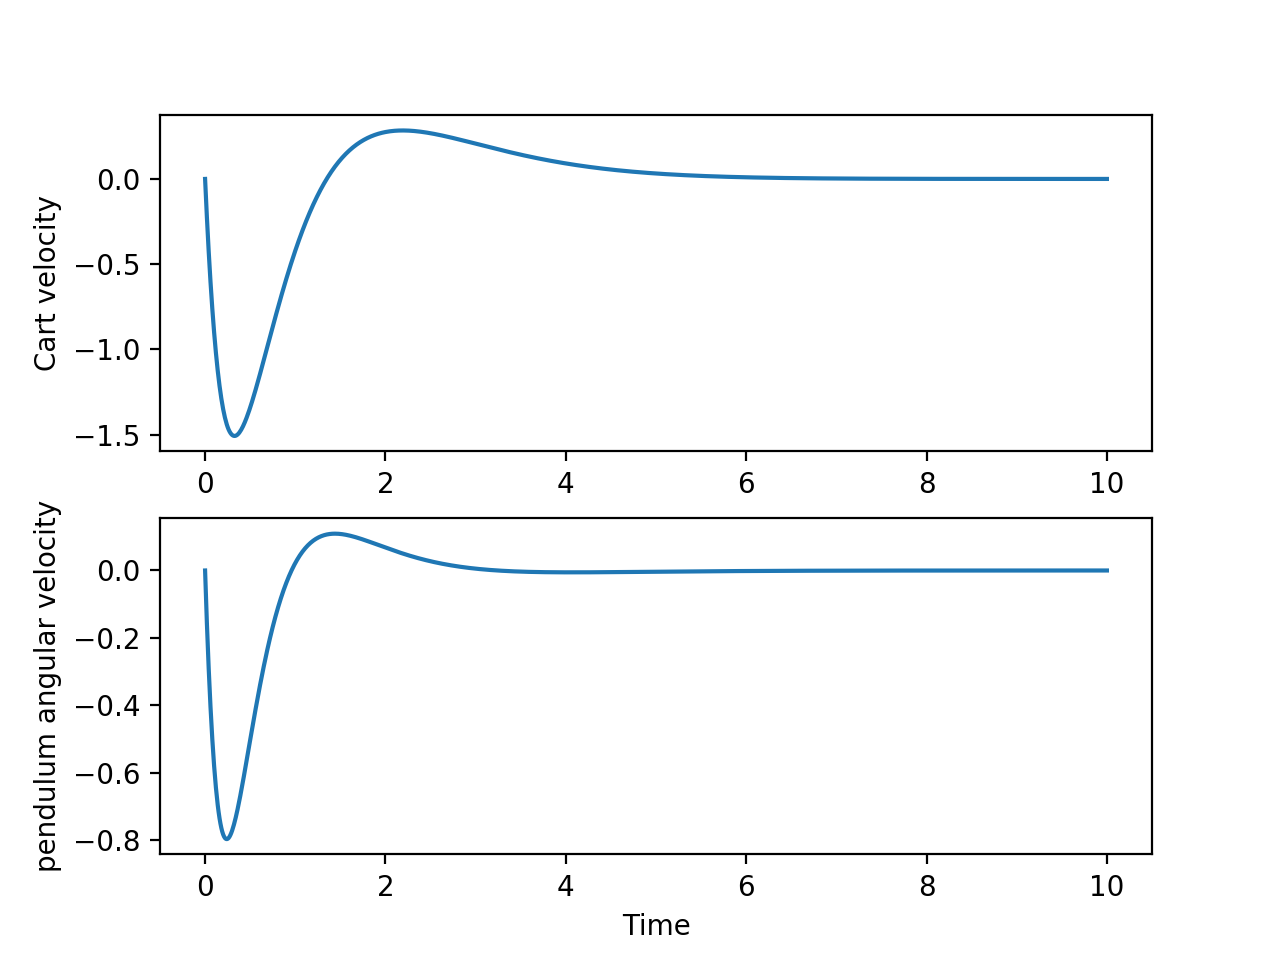

<IPython.core.display.Javascript object>


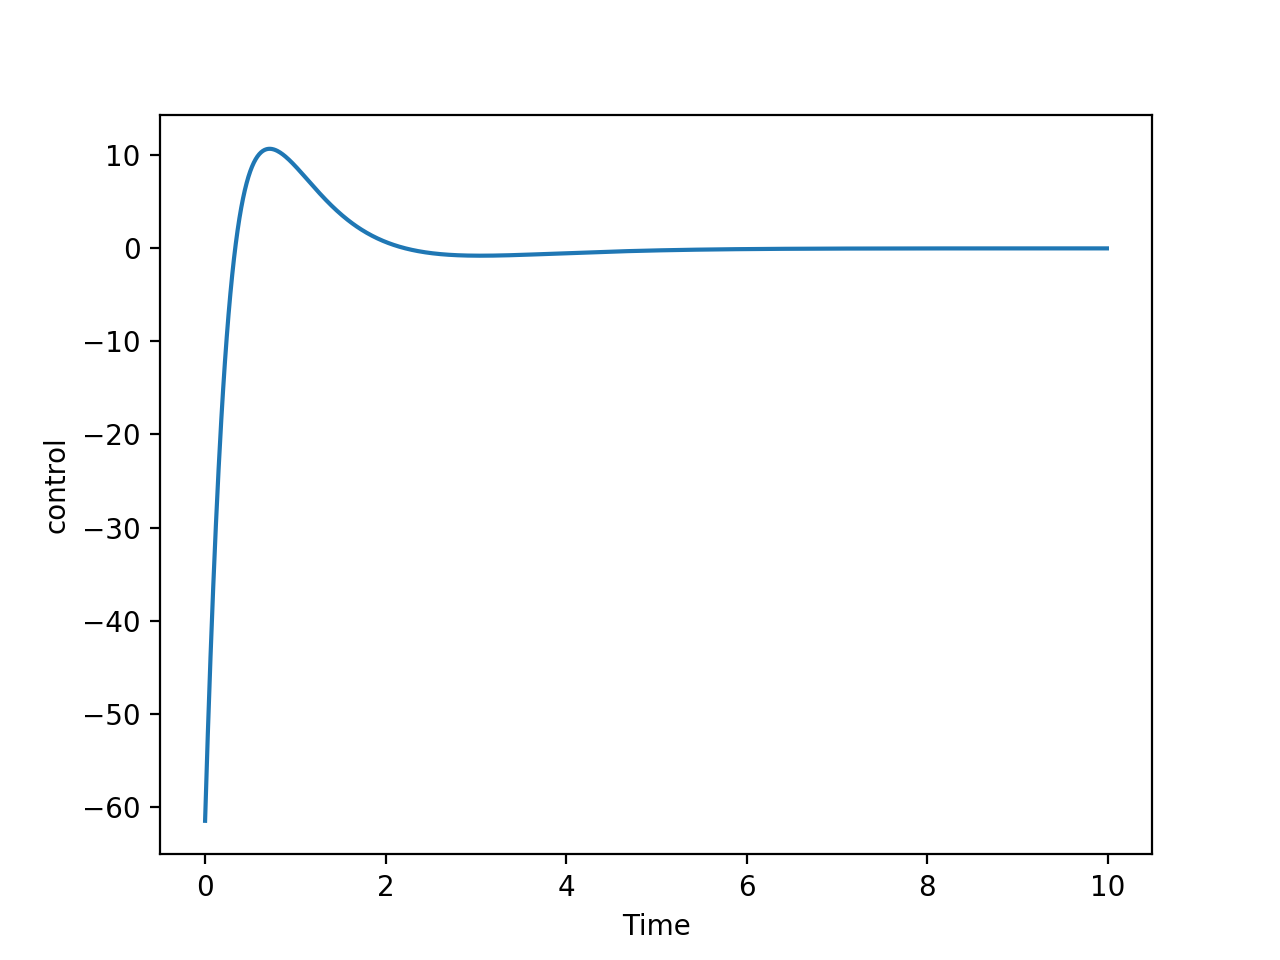

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAA1jW1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA+mZYiE
AD///vdonwKbWkN6gOSVxSXbT4H/q2dwfI/pAwAAAwAAAwAAAwAAdaFhgCmhz+EeJXEB8N6fIJ7J
rhIV+NN9XHf+yK6HeTLxVohwsVcDo5RFQnt96ggNjzTuW/beQ9Ceg3f9LFZ5ZPoaVjdmAKgN7/Gc
Kr0gtL00uCkVv1C53J99XsNJS/gNuHwTwL/869qoBhYjy5uu8WFFmrWtWDaRdcnj8LIQheD+ZCpx
gkynhBs7lzV0l+dmgpnYqcFe9agMwPZxfZ6TsAXXBMimcd4t/zryQN1fDIYSk9uOyNmB2dbE0nan
iGuaDdg1QjhVvUgGjEZ5vRM7EsCj1LZlOyN2eVBD9ggXgtoRXyLV35nG5BTBuVuxfI/uRIpSQuI1
aQOsOZM0jnlxJWF6Z8su0s+VaHZ38DWb7+nlX8NzBrLW7/+N1GSk3ln4HeXKC7DRwLQUi6WRR4CT
6rz0yv60q2FbnjO4O3hX6bbkHU2e+lFON+pT/LM4Pf5J2kYC6sPWB9ByzsY7JGHi0cXceL7lDUkd
7/1S8MBC2htkOO8bqS8nYFjLgF5ggUQNuU0ZnLTn1zgl/cRMg+yhIJPSEY/iiM4o5HL/EGPgULgw
kum+6KILiIa6WyK7qQZsmFDZb6KWS7REK2zc03Bf2go2YLnhYgNgtrVg1q/ePRzLiAb5gfcF02a8
yJN2Jln+EfcC0lTJTCUu6ZnWINoHbV43bGIiu0eN/YQXG+7O/1GiPCWUtxYO1DwowBiCmqmkX5Yj
v4WuoBipmmNioinMNP0kpealk/mlo9w3J1Gudtril8DBUDUjk58ZLPeQ7y+1d8aYhVeQXkmKSBcW
WDyQzpBUqJTQHOiO2jnCD8Ag1k+jWCs7RnXst2RmxW/R8+u26jehqlLMsBC7uEg4Tf2GactdrWDO
XLWYBBh+9JMGDB9/PmAnfmbaHGqiEziRN10BVx1shZUr5ucaB2LoyijDbDT0/KPb3PZh5P7iYwPF
0PYM6in64XaB6GgAAX4HXG00/dA3eklX7friM2Kiv/7gBcYrEhOEYy+XzfCHGhbmRoIZqAN97vUx
b7pmBgIeFu0qMi8SQ+S2d2UNEcv4MwMLT/xV+QTA1e3A5cXsiCZaMg5C3QsUNnEYS/AZShvQts+W
Zvi5abf//GDXfW3zJU5xfXbIIRsS2Hkfw989uosA46RROlWwti3UldumujkpLi3x9PIzhcN4bnju
bAMbNE1wnqriao6cYJuC/SgKByPQmWMU4ULkUttooZVGNEOr5ratrbJ9VvjcXtts/KF7/fFJJDh+
X+Tj/p6xNIcEwc2DeOGBJgwI2rwBtAAAbVLNNGQ6ZtCDgObeeutjJBdvvG+2EJY8qzzVVhtrFoUa
WC8M/ssdqTHgirH5YcXmZkchngQlAmeqQ+/LmY3zm83SeXy5Di/4yM4Fv/gACshE/0BF94qFsmai
UJf9WgV6W4lWsLq+l4lHpPwLdnNe8dUN5I7EgdbmHLaSTaX//VBFqPYfl/BeCRvDAZVXo1vmJfuJ
yBe/fE5y0qU4+TyxSwkFYzmWXPeUF8fR0WrrBsX5VMAjNNjiqtqQBd7Qe+Lnq6/nREAKUhg9uw5Y
fZmkfjXZzcBWPMZaONpI3fmbfASJntmD6C3yhTA35/tjlbabySmML7aWftXQynwP/kcyGFFMpINi
S0qy1hIgkfAdhyuhoiXCAoQHOYSW711kEg3wZrBYCiyMR1tR7sbIfnDrdHwerV8bk5PG3PZNf3Gx
SA6vK1P9gVquqQlGC7dXt+amz+mV7cW3xf2t5+htJJTG8YnslTqCGAvhFmdHbyyb2VqpIJh5WkXt
4SfTJvfHI4VFbgPDxOr7ZAwgdfwu+Df5sAiu4CQIXOMVtSo8ys8NZTQZx4rwHZ+x4nAj7CWkMhch
129RmGILDXT+cokArE/d4stG1aSUgRNU7DAwYdfRwcqaiyJ7JVhK9T+NRQAwePNYwN89W8i8ar1g
iVfgYx/UPQ6glcu98/rPBWV6N5sOsIpG0xzH1GM+J3aIUaYsLnyHZwAv+X8KaTSg2s8X2IHTqqH5
iZvv6VhCWn0+sWYpYQPDB8zKouTmxC4lEkExwClD1KenZ5UWp+wT/2ETV6ua0NyQme6ZI1XOS8EZ
gFlBs0IcnXQwjo/Lk7IHIIPtevBSqkJzunYMGs6X/sYXTmcpVm4wDobBwH2MPALEXEsc3wn4sYXF
BGdbcZihJIeeYlah416JX5cxohiVHkhgXtHcmGr3Vj7mHBK0jDETdS4DDGDCwulShE0HbNoGKGTe
sH1qP5Nvmg5cnw5GzRWTfB2axX2ApWNjcpmOUQI3VVjDYmI3LGhr+/M07aa47l/KZnC2MvLtMYnP
WwoctlkCGGAiXjBH/BrnvXKzSVJCTYPTXWEowQrY9lHt46Cm5DXfb72iSF/TApGPPp/W7sAS1JN0
9QjOhfJQrvQGd8gVassoXlMoBSnQOb3gIRfEfAy3qReCNRddUsqdlnOnwKKo6gzTv4ubIpHo2lTz
gAQjqwTAcL+GsTNP/f9a0ZdbHpO0YpNU2AfOchuKEJXj8mOT0aGmz2DNu/YigJnmMSivVyGniK8S
YY7/T0/e5KRvbSFiBb06DQYrwU0+mFlIcAjVEF6+zigcWsjBfdCe4cS8NSgYHlqWUMkYKwPhciyZ
UX4KhON4avHy2eZsvh7fxDwIHnR1+6tUAAAN8vNB1xRoAZEtdi8ULg8IKaz+6/u6hjROcLr5eD83
8hPKEB5Tlgjaxn5sUKiipKVP+PoxZ43LnmaP/0EMfPWc9/ngDwhHGIT5jFqZJPiBd67QEmuHO00f
nruQsPlKPwSNofluNrQUzj8QpOHUvoAB3F8699bVP2rWx4jzT4sw8JwpPPdAYUfpitAhFr3pExt5
vxNuNW3eMVjilqwVViu46

In [7]:



# we create a linear controller considering the resting position z_bar
def inf_lqr_controller(z,K,i):
    z_bar=np.array([0,np.pi,0,0])
    u=K.dot(z-z_bar)
    return u

# we simulate the cart pole and display its behavior
z0 = np.array([0.5,np.pi+0.3,0.,0])
horizon_length = 1000

# for this infinite horizaon problem, control is time-invariant
# we just use K for the whole horizon 
controll_collect=[K for i in range(horizon_length)]

# simulation
z,u = cart.LQR_simulate(z0, controll_collect,inf_lqr_controller, horizon_length)
t = np.linspace(0,cart.dt*(horizon_length),horizon_length+1)
# state evolution
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,z[0,:])
plt.ylabel('Cart position')
plt.subplot(2,1,2)
plt.plot(t,z[1,:])
plt.ylabel('pendulum position')
plt.xlabel('Time')
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,z[2,:])
plt.ylabel('Cart velocity')
plt.subplot(2,1,2)
plt.plot(t,z[3,:])
plt.ylabel('pendulum angular velocity')
plt.xlabel('Time')
# control evolution
plt.figure()
plt.plot(t[0:-1],u[0,:])
plt.ylabel('control')
plt.xlabel('Time')

animate_cart_pole(z, cart.dt)

4. The following simulation shows that LQR controller cannot stabilize the system, if we start with the given $z_0$. The reason behind this is that our linear dynamics is merely an approximation to the original nonlinear one using Taylor expansion, which is essentially a local approximation. In other words, if our initial state deviates too much from the resting position, around which we linearize the nonlinear dynamics, our approximation is no longer suitable and hence our control based on this approximation no longer works. 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in double_scalars
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in double_scalars
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sin
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in cos
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in cos
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sin


<IPython.core.display.Javascript object>


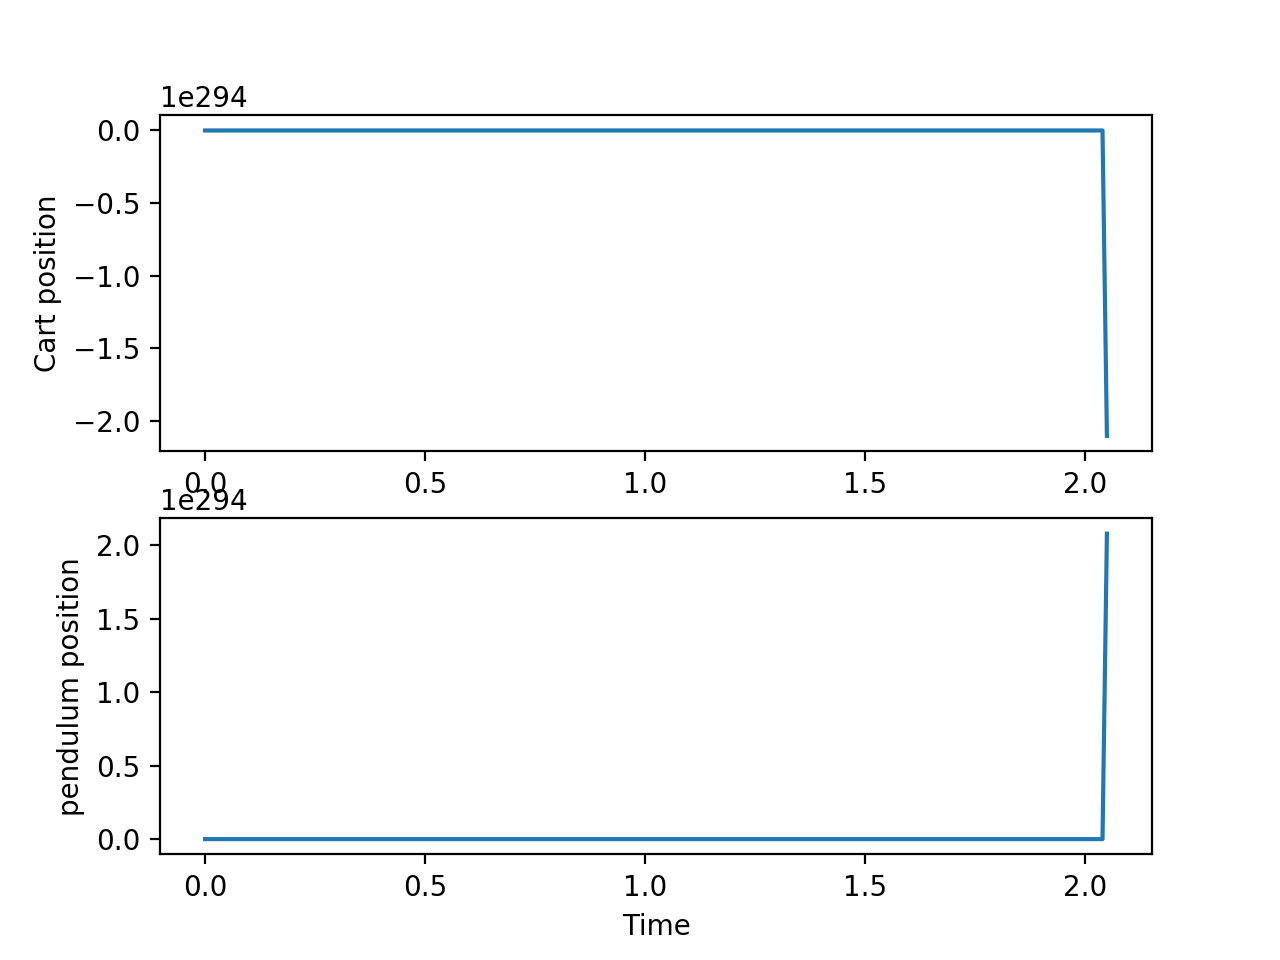

<IPython.core.display.Javascript object>


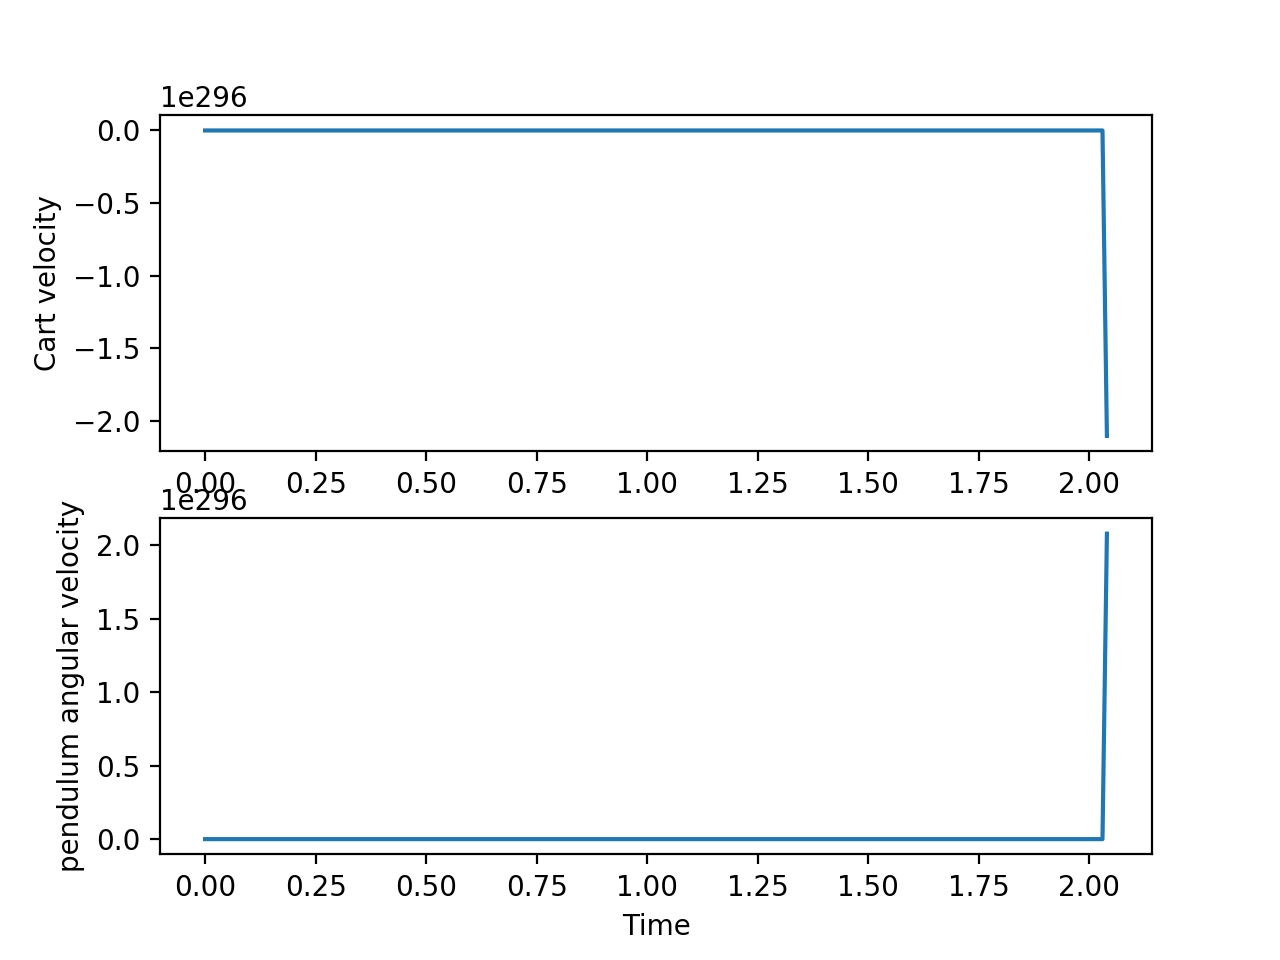

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAAeVG1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA+VZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6J4P4R4lcQE8kYWQT6
y3KCuinXVt83n9H0S0FxzClEFKxd1+TNS++zCta62/NP06dt9j0J6Dkf2rHaFv+dr20t1Bp3zX58
DBmkFpamrwUtoW26plf3qfo7kHaQyI08hEByMoaqItBilNRZ9xftAaNrfFzgbRx0zytlSZ7wyT/A
hWDCoOtQa0dEz95yhN3uVkH/sJoWqLvH6jo9pLsuTBPgi8kL8+yRBKPqVQ/YUDgwspb8Gnl6iUwZ
SurlWB0QXIgiBsb9xLD0CubzvixG8obluC6puxpOWyCYkAbatLU9jaC6EwsXEj+MlAWQBEJnFmon
oyTi8n0C0BKkW/r4xDr20Mgn+As9aPbE4158j/U2cEGxsD+LAx8n1ABol8bPKscdoc/NLOlg9pn4
16RMT+6SCUf+x7E0q2ZblRruWmmoXBKThvp6G4jbYufZmTyt9luZFQv8xJpk228ds02YM4jv6ZIB
FWGv3PskzSqwRg20hl8dWXb8XiQpNAnR7X3kzDHP12RsCprXAaCJ0awqwnwjG5ftGMinR8tqk0Lm
VLg8lglrQD0I/Gf5aahDAisQwxNGHtZ1sVZPCBF4qxX894qdLpdZpTq+h6zzPomEo50v9WthAGI3
v2XQ8TntUBwJ7aDPKnTjf1+PWI87IS8bUH+ygTpZ8SmmkX5Yjv4aJpMQaYnuEhP9Xtxp+tsee4pK
JBtfARHRb8IrYyicQuuTJlGkJnQvOiswoqLCmoT/DxpCid40RTFgQkfY4SOdGsJ7aDPKnIaIQ+aH
/xGGOOCcykfvCsHWxDZaR/QzX/g4RT7yBwxXo8Xh3KnG/HCi8HdeCgcisIs7iR/wmPjl26AAAFRP
+C+SFNSgANXhS76naeZKkbWcV/yXYoCevJkwVRvGtb6K46Kv7a0wZfFP1Qn5b2/lu6PZn5fEhvm8
2WA7Nx/3tcCmjYQL7fWXSrsZ18MKOcTRRtL0xJ+LQVYNgMoQYuvYBHgDblkb4NdwNmuVYAW2cBne
uyQfkONcA6k0HnCe6JTnbN3Q+fZrxBbGe3RdEdR/4xLPHyZsz0YWXAuHC3N60cPX3rLL+6cdVyLB
/3vYF4h3fMI4AB8TNtqwt3DqaHGm9ym2W1zAVkVNjNCr+g/rYq3Jj6Ee8dUNCEA/aU+e7mj94KDi
FYURd98exQH2lH3up7LfdFNk00KUzqMMNN8vWc7Ec6YFSEQwefEcX6SpeFxk1kqKKI75VMAjNNjk
Zz7JcMe0Hvi56uv3BG4FGUWAgWEE9CaR+NaceSN48gFsWp8GSDHJVrvbQf5lIQ6MSggl3B4yVDLu
iZfXgnvJ/FKdKuIUxf/7onEj6DCb/OjAhyLv42t0FVvabRQI3+YOfoB+wa/nU95UmDYceTRFPY1k
YaKYQrUrTIw5YCGIHys/ehS08chOI6HlRT8zpclk/9Goz7tMuJELPViIsnxjAsrTrxUEYkQ5bQJ9
pc+MIUBF5zD+UoFm6cm6I8qWkVqwFk2xwhFRf6TBI6DPmDvK8jMgCO7Kxo6fnmuLFLWwEaPQdd0U
kDuSWJ8P+cTjNotXYZpI5IDZF/BwGyev5OQLg1W7zi5YUjIGwH59KdBqxAuoNTbNK8XgAmDLv8T9
NJFcABVjOp8Hbw7TlnH4lOfz6MPzOjyAMHFueeLhLghctFsLT1c02TCjCeny3yWCL7qyh7bvBqga
8F8M9j/hwQubYz5Z0yvcFVJCPVNkIgmxMpVlYBe2tWS0UlQG7rqzVT9fY+inpyXrCxVGmrKi+3Po
50O6B9PuCkPVpI+++AzHB9HUAsj7Wmef6puFL37/DEG/eC4gzirqgrgJvs+0PzuAgm/9n75fN2zr
DWKdihLk62COwAFiuF3Ptvj2CmGdzbYP74f7mkxrO9IRdkYp45QK57SbcwmVQkn39G+L1KlU/YZr
ysRGXA3Eguu4DsbDsHvRJJ3M6jsimfqE/cLwYCnPLDi54+hEdftraf24rROqgiEzoapcFCpYIVse
yj28dBXYREuGH+FbHKpbJQbYEf7kpgS1JN09QjOjIT7gwwFFPDX5/b1mINhQ/07Z5eAhF8R8DLep
EAMflhic0gO+fWSMPBiMWGpPvov3BQ6UWffrGi+e/wsZKfaWmAi29vxBszIptInEOA/8w903xaHB
46sdzwzJSjf4X8NRbQ0VFm4/ICSvXayx15dX75F4IH0op1xqUrRS56AHQMMbleG8vFnKafuu1Nhv
E2apoXYB11HoARfWRAb9lLdo3qYRZGQZtC/blw1Fb8C6ZrHH31+UD1igoW7LWyLN89Ba2NtIWE++
Fg+AiI9dHweKgKL4vWAA7LP3QjuiABDIjKRgCLbN3sUSmpxrfbON/Crci1m66TnaIupwfLhpbGaw
9oVPcCuRGdF/EuEPcdE3eTGG3GyapBdVyg6fYmeox+1mvXmmHMKW8GIAlDOryqmI+UaD/So1fWHx
OzrZjTm0RjHI9eLSfRGIsUY0WV/OUZrHTg9lbrk2KyUOvXyAkocsGCAbZJyqDuxRiEVPl1GPlJgo
gaU3MOaRNhCygMbpgbsCni9XJKlXrFlLp6lPczYu4WOvGH3nJgcr4K7LYLAXdI3jGcT41bd4xWMm
vvKarFdx0yLWuheORyCfcY2UETHdxJ88ACFFtaONFh+Hg0IGcqT3BYmOD9gLUmFgn/WaP2vbFUxi
FAYuqmlL2epRVW1xJ1B+CSbqom2emcB94JUi3xgbEknII9gZ8ufH1otN2yAkCPEBcNdaUUBlS1s4
SXHlLTcopzZUmFUjQc9SOs1mpKmlWnMgvh75T/TqDDEd2RboUgW4rhqUwn1eVF4kwXuw+orTr6ba
8tSh98aOE2AvGX/2wYLWZ

In [8]:
#initial state and the horizon
z0_1 = np.array([0.5,0.3,0.,0])
horizon_length_1 = 1000
# the optimal gain is a global solution, we can use the previous K here 
controll_collect_1=[K for i in range(horizon_length_1)]

# simulation
z1,u1 = cart.LQR_simulate(z0_1, controll_collect_1,inf_lqr_controller, horizon_length_1)
t1 = np.linspace(0,cart.dt*(horizon_length_1),horizon_length_1+1)
# state evolution
plt.figure()
plt.subplot(2,1,1)
plt.plot(t1,z1[0,:])
plt.ylabel('Cart position')
plt.subplot(2,1,2)
plt.plot(t1,z1[1,:])
plt.ylabel('pendulum position')
plt.xlabel('Time')
plt.figure()
plt.subplot(2,1,1)
plt.plot(t1,z1[2,:])
plt.ylabel('Cart velocity')
plt.subplot(2,1,2)
plt.plot(t1,z1[3,:])
plt.ylabel('pendulum angular velocity')
plt.xlabel('Time')
animate_cart_pole(z1, cart.dt)


# Question 2:
We would like to use the linearized equation to compute an optimal controller that makes the cart follow a 0.5Hz sine trajectory of amplitude 1 (i.e. $x$ displacement from -1 to 1 meter) while keeping the pendulum balanced.

1. Write a cost function that will help enforce this behavior (be precise with the variables you use).
2. Compute the finite horizon controller that creates this behavior for $N=1000$ (i.e. 10 seconds).
3. Test the behavior of the robot using $z_0 = [0.5, \pi + 0.3, 0., 0.]^T$. Plot the time evolution of the control input and the states of the system. How well can you track the desired motion?
4. What is the cost value predicted by the control design? How does it compare to the real cost value when applied to the nonlinear system? Explain.

1. Our cost function is defined as follows
$$\frac{1}{2}(z_N-z_N^*)^TQ(z_N-z_N^*)+\frac{1}{2}\sum_{n=0}^{N-1}(z_n-z_n^*)^TQ(z_n-z_n^*)+u_n^T R u_n,$$ where $\{z_n^*\}$ is the desired trajectory to be followed. To be specific, we let $z_n^*=[x_n^*,\pi,0,0]$ and $x_n^*$ are sampled from the sine wave every dt second, while $Q$ is set to be diag([20000,20000,0,0]). 

In [9]:
#horizon N=1000 we first compute x_t
N=1000
t=np.linspace(0,10,N+1)
x_t=np.sin(np.pi*t)


2. To be consistent with the dynamics, we rewrite the cost function as $$\frac{1}{2}(\tilde{z}_N-\tilde{z}_N^*)^TQ(\tilde{z}_N-\tilde{z}_N^*)+\frac{1}{2}\sum_{n=0}^{N-1} (\tilde{z}_n-\tilde{z}_n^*)^TQ(\tilde{z}_n-\tilde{z}_n^*)+u_n^T R u_n,$$ where $\tilde{z}_n=z_n-\bar{z}$ and $\tilde{z}^*_n=z_n^*-\bar{z}$. In this case, $\tilde{z}^*_n=[x^*_n,0,0,0]$. The detailed computation is shown as follows.

In [10]:
z_t=np.zeros([4,N+1])
z_t[0,:]=x_t

In [11]:
# define a function for computing LQR control for tracking 
def lqr_tra(A,B,Q,R,z_t,N):
    # index denotes current time step
    index=N-1
    # initialization
    P=Q
    p=-Q.dot(z_t[:,N])
    K_collect=[]
    k_collect=[]
    while index>=0:
        # recursively compute the control 
        M=R+B.T.dot(P).dot(B)
        K=-np.linalg.solve(M,B.T.dot(P).dot(A))
        k=-np.linalg.solve(M,B.T.dot(p))
        p=-Q.dot(z_t[:,index])+A.T.dot(p)+A.T.dot(P).dot(B).dot(k)
        P=Q+A.T.dot(P).dot(A)+A.T.dot(P).dot(B).dot(K)
        # record every control K and k
        K_collect.insert(0,K)
        k_collect.insert(0,k)
        index = index-1
    return K_collect, k_collect

In [12]:
# compute the control 
cart = CartPole()
Q=np.zeros([4,4])
Q[0,0]=200000
Q[1,1]=200000
R=2
A=np.eye(4)
A[0,2]=cart.dt
A[1,3]=cart.dt
A[2,1]=cart.dt*cart.mp*cart.g/cart.mc
A[3,1]=cart.dt*(cart.mp+cart.mc)*cart.g/(cart.l*cart.mc)
B=np.zeros((4,1))
B[2,0]=cart.dt/cart.mc
B[3,0]=cart.dt/(cart.l*cart.mc)

In [13]:
K_collect,k_collect=lqr_tra(A,B,Q,R,z_t,N)
controll_collect=[K_collect, k_collect]


In [14]:
# LQR controller of the form u= K(z-z_bar)+k 
def lqr_controller(z,K,k,i):
    z_bar=np.array([0,np.pi,0,0])
    u=K.dot(z-z_bar)+k
    return u

3. The following simulation shows that our LQR control tracks the desired motion reasonably well, as we can tell from the cart position plot. Despite the initial adjustment process, most of the time, our cart-position plot looks like a since wave, though there are some slight differences in phase and amplitude, compared with the genuine sine wave. Also, as we increase the penalty for deviation, i.e., make Q[0,0], Q[1,1] larger, we can obtain a trajectory that is more close to the desired one. 

<IPython.core.display.Javascript object>


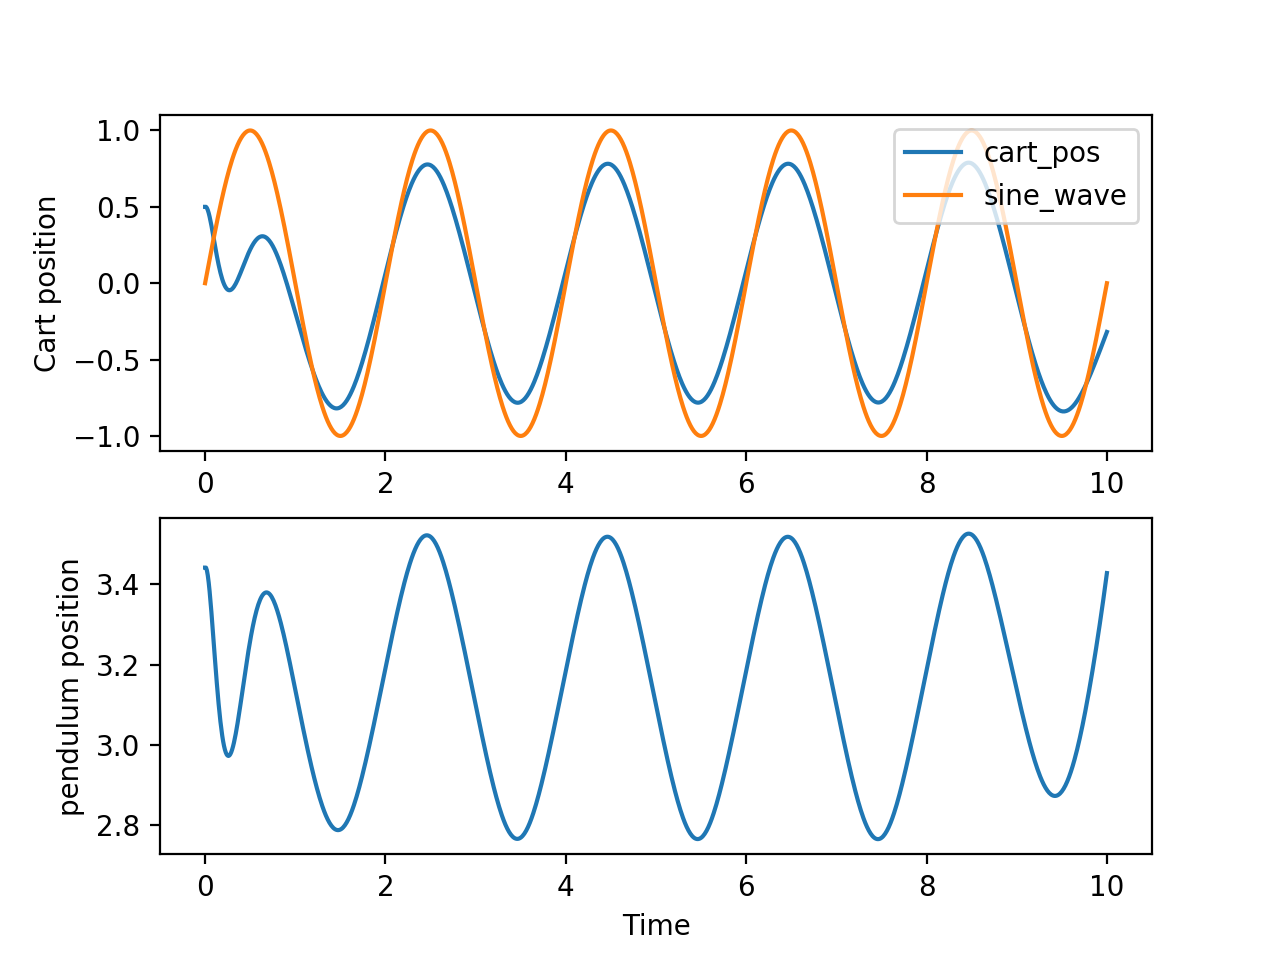

<IPython.core.display.Javascript object>


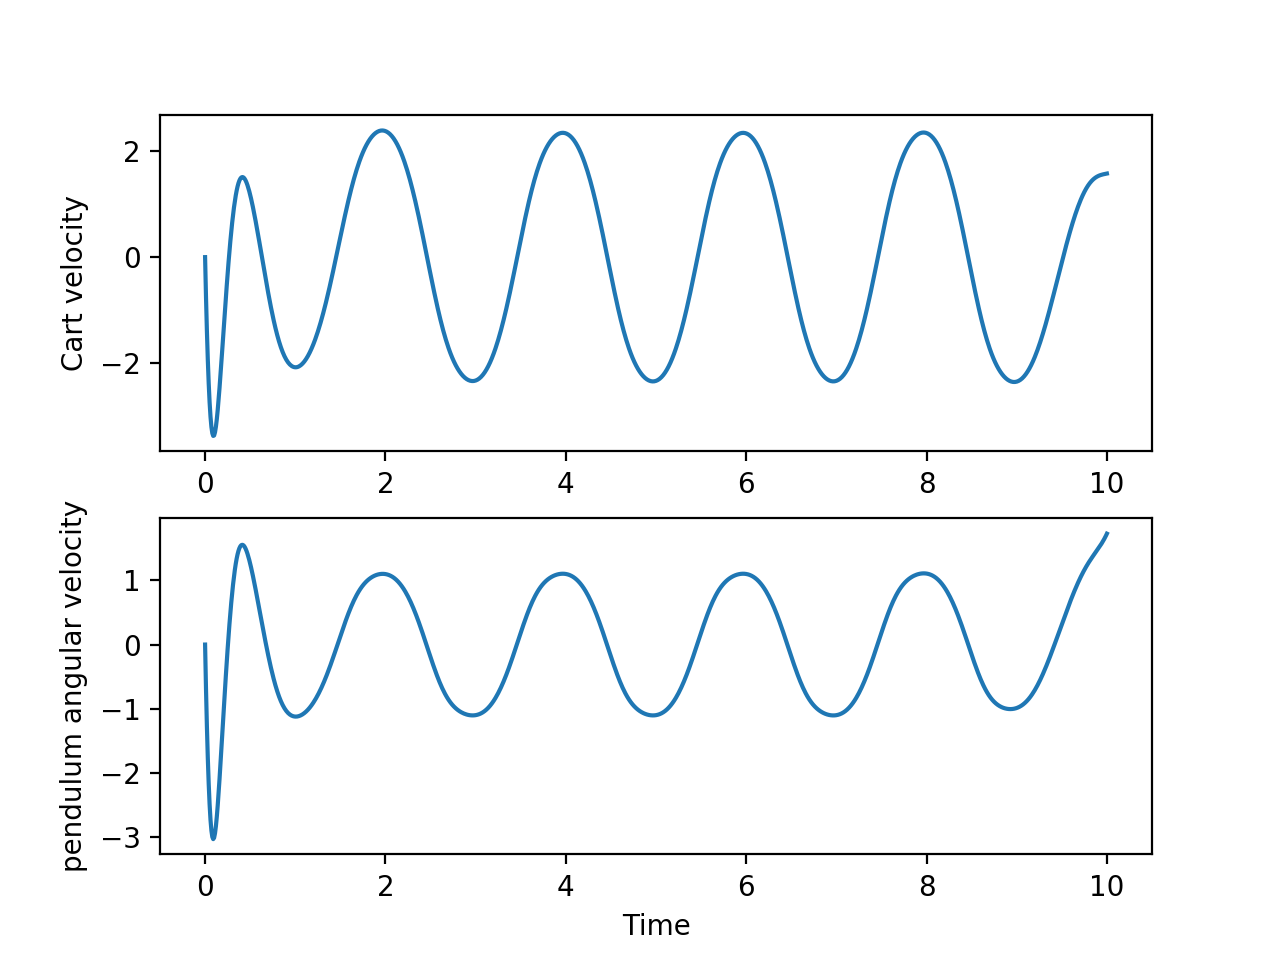

<IPython.core.display.Javascript object>


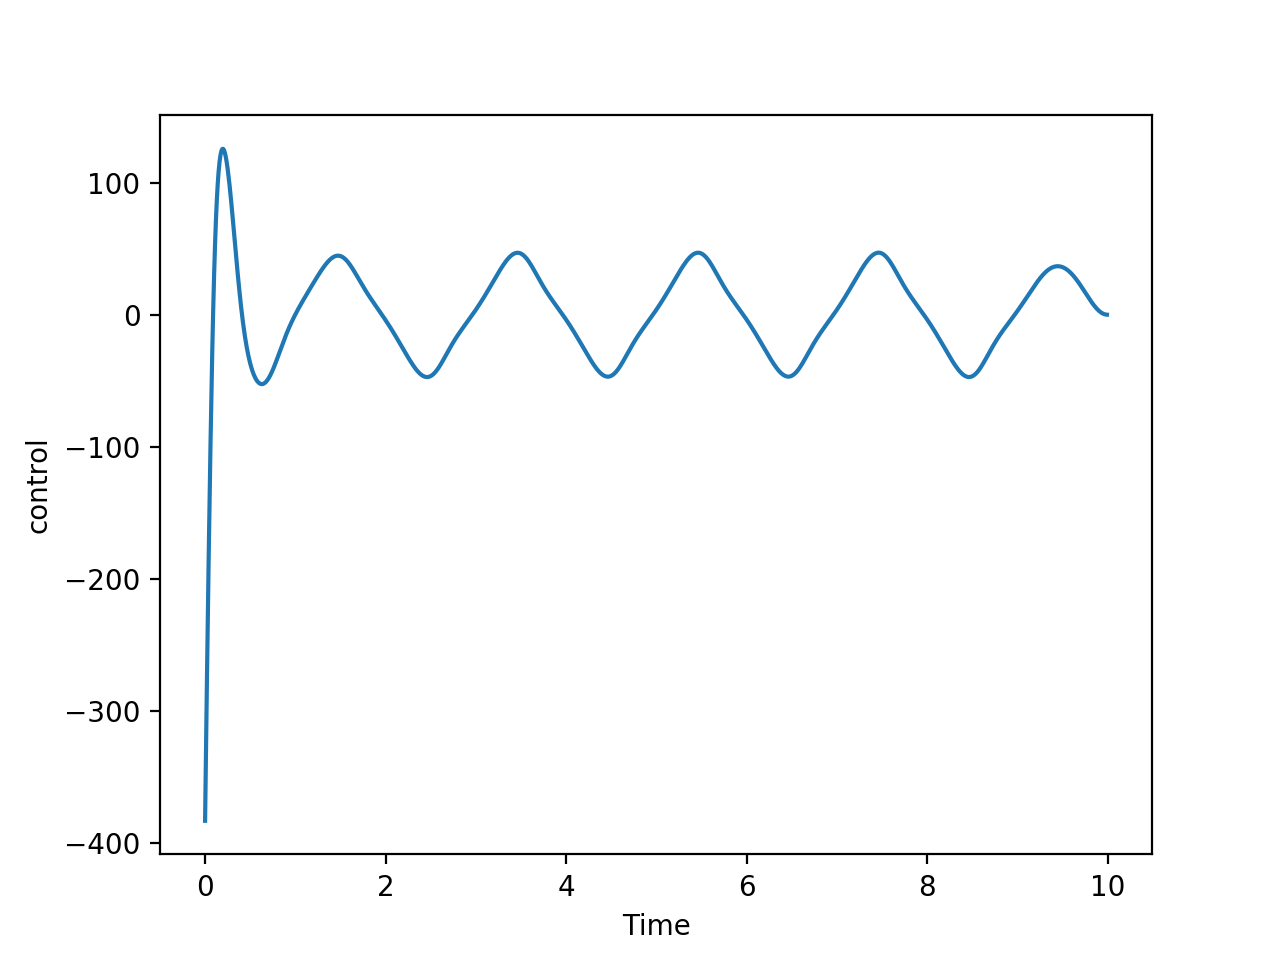

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAB0pG1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA+sZYiE
ABH//veIHzLLafk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAAMACpJYniKJ5P4R44+ABsFZPWF6
8K8Tdocf0fLGceooGifZzKP1qf6GISL90/nuYWAO8u7HsstYLSQJV4Lq/uW0A7s6ctYY5gnj9wP2
lyFhYuM0IF8mYouoYX5Pvq9s3KO1gdbyKyRReYlQ8Jhj2ZxVZ9xftAaNrkkRnBcUtp5WypM93Wn/
w4VgwqDrXGSKRM/ecoTd7lVBQG+aFqi7x+o6faU6+WPJk07JaciEI6Yzb1U3wMrAQ8mUK11KvUT6
lJlupEyYxUfiCISIueeHzgvJ3XfiJN/AnU+9dl0NcYyDBWiePpSFxvaSzXi0ACsX4D63q+F7mq5F
BWy8kBMAEjtzcmz8ZmjNPgNqVvpCijmUfywCu5DeeZYb5VVwP8ZL6vVWc3i6Yx8f5qgsRFBP33J7
azo1B8ZlzxaNw63/zBjJF9qMVy2lAlRy9szCz1InfZ/p62Ih48t03gz+YDEElG4RFjaJyp/Vk//z
DZPTsyt+KnmlsxV05SzZWGnCq/eu4QURugOD3GGZfKnp2M5WcqZHCSoLKMavgbQg+ZrGZWghrY7x
aGgzdtW3y3wPgGBD1Qn/1A2FYbsmj+yTXFGU6+smeM/eM0LLCdbgGrnziWfjP8tN3x3kWDtjhXJl
d78USVQw766JiqyPwZsi1Lm/CPwRaSpkphKU1yPNymYAgLTr4jPuzTw8J7aDPKnUZfmmg6vdq/bb
4XZhr0xN8TfVNIvyxHfw1LY81mhURwvSP78NP0kpealc9UOyHN5ke+m/uGBH5Q3dKydTk2dULbmu
cfXyXKXUWMrOStI+Mq9q945DzGP6sZC7Syj9isHAykbpSGizD9JcBEPwRrwppBPt1621Ax8uiZTM
y2NVtgJg7HO1Hq6mnN0WbOSUV152SH9fbHVriNhAwlPj8UFQk/xC2paIqwwpuj7ZqOBpQuSGy1h5
sEiuYHE/394rU2f4W+M0fPcKdWzykdmwdJIz30AAvMkbMw5KQ0sfVgNAIgJ1HijT//7MOpO38jk5
MSOZPtNrS65v8xwjNgBrAd6mNpqJHF8A3V5TEBT/yFXfQvJnHMFlSZz5ppQ3mApDWsLT+TLxNj9j
wVvuyr4MYJkj0riaZLiriox4mI179Pbcl9uzDNnIvzp6E40okMxjZRiKfWci/6VpVuNtDhKQRCGb
yt1m77x1Zj+I5TJMlvlORGEDVEL9jh1edlFeUYeAH6Y7n7OVBL30n2a5f3fsrxMrJgD7K/W3RDxc
hf9EzwOD2OQ4oxZxKz1pA7ZcC4dBWOtL6evvWWX90461kq4iu1QAAcxJcoO+WbZNskmlLAi/sJYW
JAgxpYYGTb1Ls0d50bw1iiT7blAUNGEfvhPmtDHB063alD1T5JpiHOxbV0L9ACISbdTDJJEGl7e0
NUin8eaoM0kb9RmC24bArRz+czXF47vHVDQHPJIMJ2CElO2XmNoBX3abZnqP8F4JG5ggfSrVz5uL
u4nHi27dGNyRR3l2VBEQt7qwra47bMMm1F7qT5Pxhf0t6CiswuQ6a4kc/olZI3qynk9uQ4FEzjnx
UHD+f6mPxrU+zwrHmMtHGYReJuwVvC/b0fkbCWg7M9ZOQKpKbn97omX14J8EPMR7zkOP+d9j1mmq
P56HKD2h3sbW6Cq3tNooS/LuVgIDdcqYm+nYgCKbfS8iJS7urGq6YQrUrS1fwIEKTEjw6HqX9OoD
EO2/DMLP3L9np/a1iDCCtGN/bZBHldmf8ZVRwA/5HIjwSZFigYHnPj/BqrOtIPsEN+U6gsLqvBZ5
VudD0OuN5bnipiMiQlmvX5hBZt97qBfud7UrsP14E5guSvANnwhUhDduafgx3ex7JeVZgKX6hNfu
ddI7zDvkn9SHo8+FQiYLrHpRjPa0wgADbc3crl655kmKfjtOSB76oFew3Aq1gOzR3Pcan+tEovC+
IlyTppIcObH9LtxJAJOXK3KhiUow1zO+FtfrZ7Llokrqdt6U8iirOXf4fmHuuuU2nlAAbQ01v+PN
+GDLhS3fFM3v5KRNKWQCRsePvkbc6NLMwTDr5w5EEwGpyUrJQKV4KJ8Qwa6BW7U8KZ1wkmM7zbIh
vYneuubILyFerDGgik0QqSSw7ahEMG3YYiev4wFebXYOx3jNcq6sN4Kxm0BlkX/vIcn/01t/FL9B
KfPHLL21i5KA2dVNrA1yvaEpPFgMt3/7AZRO2uFsLnEDL4HF5++H+5pMazmujLV3q5znHUioVDwE
Nm3rBNG+L1KlU/RDFJ+IjLgbiQXXcCp202QW435amdR2RTP1CftsKGn3JzY1SNWMXgpAl0X6dVon
CxPwE1qZVLEbwQrY9lHt46Dc+AXhvL5pI3NcHcqyyZ8plTAlqSbp6hGdFW+rTAgM7498CquEfqZQ
DMBvoUZxdfhU5hy1Uh+olF11PZ0XCfVp2/e5oiiZRDVs/a3lrjol60fTNOIFL+J920Xp7xBwjajO
ozk1Ls7PfSDnOMxFS99yCiqcRw+DibMxYFswIzUT73ojJVSNcxuYqcdbG4jug3vCCYZngrozPv6r
1l22U11+fK7Fpjc0eSpHrVZe/c7EObVhIRC2LsYQuFkELBym4HvBaW/9VyQplfLy3ufnkfKWzfVB
wbdbvgUpSKbdOSkFGWX/V+uWH0hVp6VrerUdFKZ62ceO80yVpzocQgr/tWUk2PBPuUahBrcIAAz8
S4UEeH247Vix1TbZMw6TnCflCMT2xQFco7DN4qXcRqk1uTTlv60UZ7WuHO00fnruWDgYLc5wtAcA
9UJhPTH+waeHUvoAB285h99bVP2rWx4jzT54+sxB6wZWCbq12m2CvcDcw2GNDN+Jtxq27xisZPbc
l9FE5/kV5Ff71WzYQrgPe

In [15]:
horizon_length=N
z0=np.array([0.5, np.pi+0.3, 0,0])
z,u = cart.LQR_tra_simulate(z0, controll_collect,lqr_controller, horizon_length)
t = np.linspace(0,cart.dt*(horizon_length),horizon_length+1)
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,z[0,:], label="cart_pos")
plt.plot(t,x_t, label="sine_wave")
plt.legend(loc="upper right")
plt.ylabel('Cart position')
plt.subplot(2,1,2)
plt.plot(t,z[1,:])
plt.ylabel('pendulum position')
plt.xlabel('Time')
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,z[2,:])
plt.ylabel('Cart velocity')
plt.subplot(2,1,2)
plt.plot(t,z[3,:])
plt.ylabel('pendulum angular velocity')
plt.xlabel('Time')
# control evolution
plt.figure()
plt.plot(t[0:-1],u[0,:])
plt.ylabel('control')
plt.xlabel('Time')

animate_cart_pole(z, cart.dt)

4. We now compare the cost prediction an the real cost. We fist define two function for computing the prediciton and the real one respectively. For both values, we compute them in a forward fashion, meaning that we start with initial state and sum up the running cost and the terminal cost. The only difference is that for real cost, we use the states from simulation, while for predicted one, we use the linear dynamics. The results are shown as below. We find that the predicted value is much larger than the real one and we think the reasons are as follows: 1) first, we our cost function is very large (Q matrix) which amplifies the difference of running costs produced by nonlinear and linear dynamics, 2) our linear approximation is actually an overestimate for the nonlinear dynamics, see the followng fig. We demonstrate the trajectory of cart_position generated from linear dynamics, and obviously, its amplitude is much larger than the real one. In other words, predicted trajectory deviates more from the sine wave than the real one does, yielding a larger cost.   

In [16]:
# compute the real cost based on the simulation 
def real_cost(Q,R,z,u,N,z_tra):
    value = 0
    U = u[0,:]
    #running cost
    for i in range(N):
        delta_z=z[:,i]-z_tra[:,i]
        u=U[i]
        value = value+0.5*Q.dot(delta_z).dot(delta_z)+0.5*R*u*u
    # terminal cost
    delta_z=z[:,N]-z_tra[:,N]
    cost = value+0.5*Q.dot(delta_z).dot(delta_z)    
    return cost

In [17]:
# real cost
z_tra=z_t
z_tra[1,:]=np.pi
real_value=real_cost(Q,R,z,u,N,z_tra)
real_value

13638997.514349591

In [18]:
# compute the predicted cost based on our previous control collection 
def LQR_cost(z0,z_t,N,A,B,Q,R,control_collect):
    value=0
    z0=z0-np.array([0,np.pi,0,0])
    z_collect=np.empty([4,N+1])
    z_collect[:,0]=z0
    for i in range(N):
        K = control_collect[0][i]
        k = control_collect[1][i]
        u = K.dot(z0)+k
        z1 = A.dot(z0)+B.dot(u)
        delta_z = z0-z_t[:,i]
        # running cost
        value = value + 0.5*Q.dot(delta_z).dot(delta_z)+0.5*R*u*u
        z0=z1
        z_collect[:,i+1]=z1
    # terminal cost
    delta_z=z1-z_t[:,N]
    cost = value+0.5*Q.dot(delta_z).dot(delta_z)
    # cost is a 1by1 array
    return cost[0],z_collect

In [19]:
# predicted cost
cost,z_collect = LQR_cost(z0,z_t,N,A,B,Q,R,controll_collect)
cost

999388116.5395806

<IPython.core.display.Javascript object>


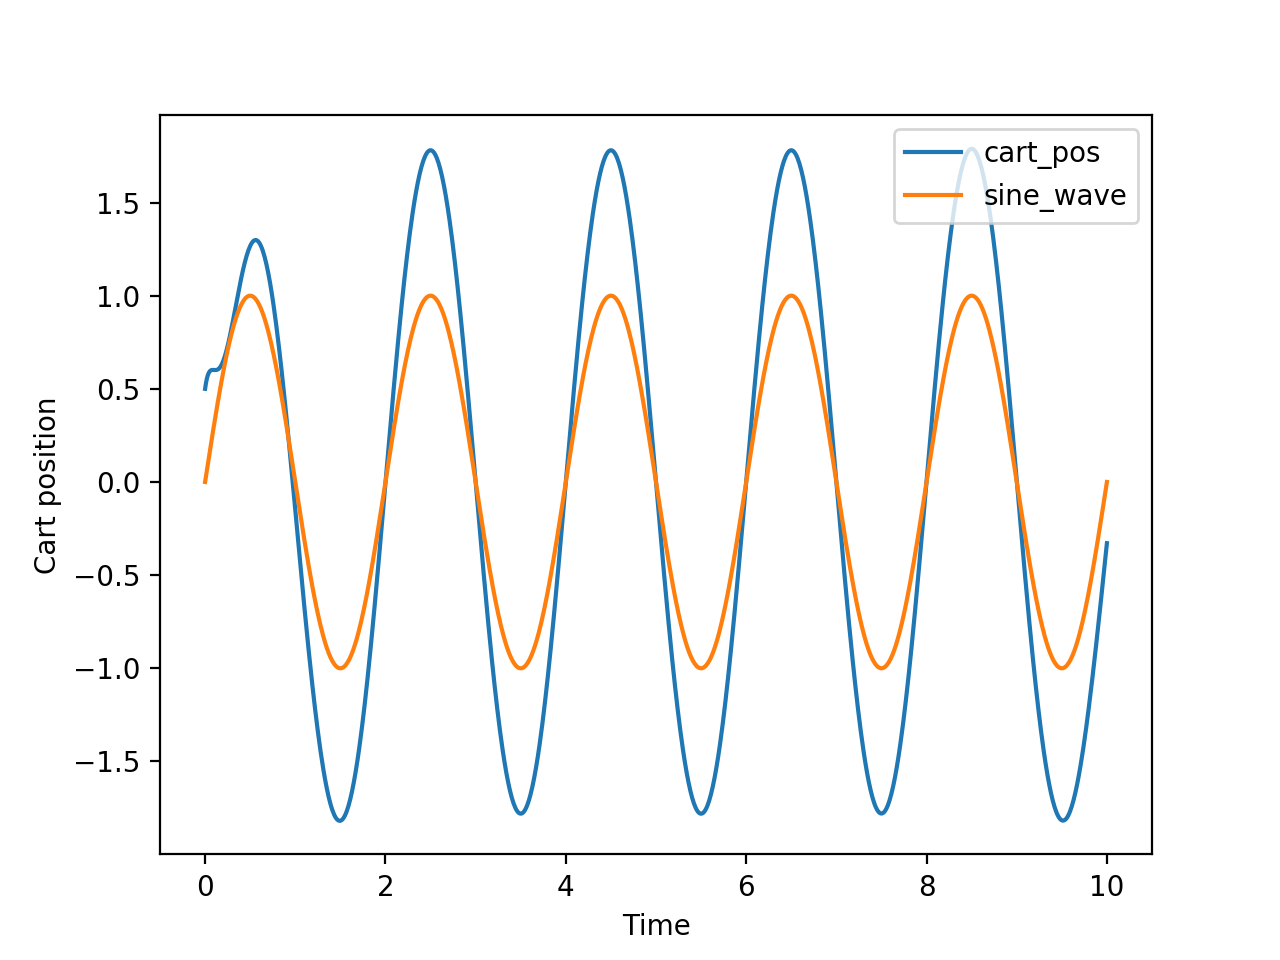

Text(0.5, 0, 'Time')

In [20]:
# trajectory from Linear dynamics
plt.figure()
plt.plot(t,z_collect[0,:]+z_t[0,:], label="cart_pos")
plt.plot(t,x_t, label="sine_wave")
plt.legend(loc="upper right")
plt.ylabel('Cart position')
plt.xlabel('Time')

# Exercise 1

In [21]:
#we first creat three matrices corresponding to the linear systems
A1=np.array([[0.5, 0, 0.5],[0, 0, -2],[4, 2, 1]])
A1

array([[ 0.5,  0. ,  0.5],
       [ 0. ,  0. , -2. ],
       [ 4. ,  2. ,  1. ]])

In [22]:
A2=np.array([[0.5, 0, 0.5],[0,0,-0.5],[0.5,0.5,0.5]])
A2

array([[ 0.5,  0. ,  0.5],
       [ 0. ,  0. , -0.5],
       [ 0.5,  0.5,  0.5]])

In [23]:
A3=np.array([[2,0,0],[0,0,-2],[1,1,0]])
A3

array([[ 2,  0,  0],
       [ 0,  0, -2],
       [ 1,  1,  0]])

In [24]:
# we then compute the magnititude of eignevalues of these matrices
# for the first system
v1,_=np.linalg.eig(A1)
abs(v1)

array([1.     , 1.41421, 1.41421])

In [25]:
# for the second system
v2,_=np.linalg.eig(A2)
abs(v2)

array([0.87744, 0.37744, 0.37744])

In [26]:
# for the third system
v3,_=np.linalg.eig(A3)
abs(v3)

array([1.41421, 1.41421, 2.     ])

In [27]:
# we now check the controllability. First, we create the B matrix  
B=np.array([[0,0],[1,0],[0,1]])

In [28]:
# for the first system
C1=np.hstack((B, A1.dot(B)))
C1=np.hstack((C1,A1.dot(A1).dot(B)))
np.linalg.matrix_rank(C1)

3

In [29]:
# for the second system
C2=np.hstack((B, A2.dot(B)))
C2=np.hstack((C2,A2.dot(A2).dot(B)))
np.linalg.matrix_rank(C2)

3

In [30]:
# for the third system
C3=np.hstack((B, A3.dot(B)))
C3=np.hstack((C3,A3.dot(A3).dot(B)))
np.linalg.matrix_rank(C3)

2

In [31]:
# we first simulate the unctrolled system
# we first define a function for running simulation
def state_seq(x,A,T):
    state_seq = np.empty([3,T])
    for t in range(T):
        state_seq[:,t]=x
        x = A.dot(x)
    return state_seq

<IPython.core.display.Javascript object>


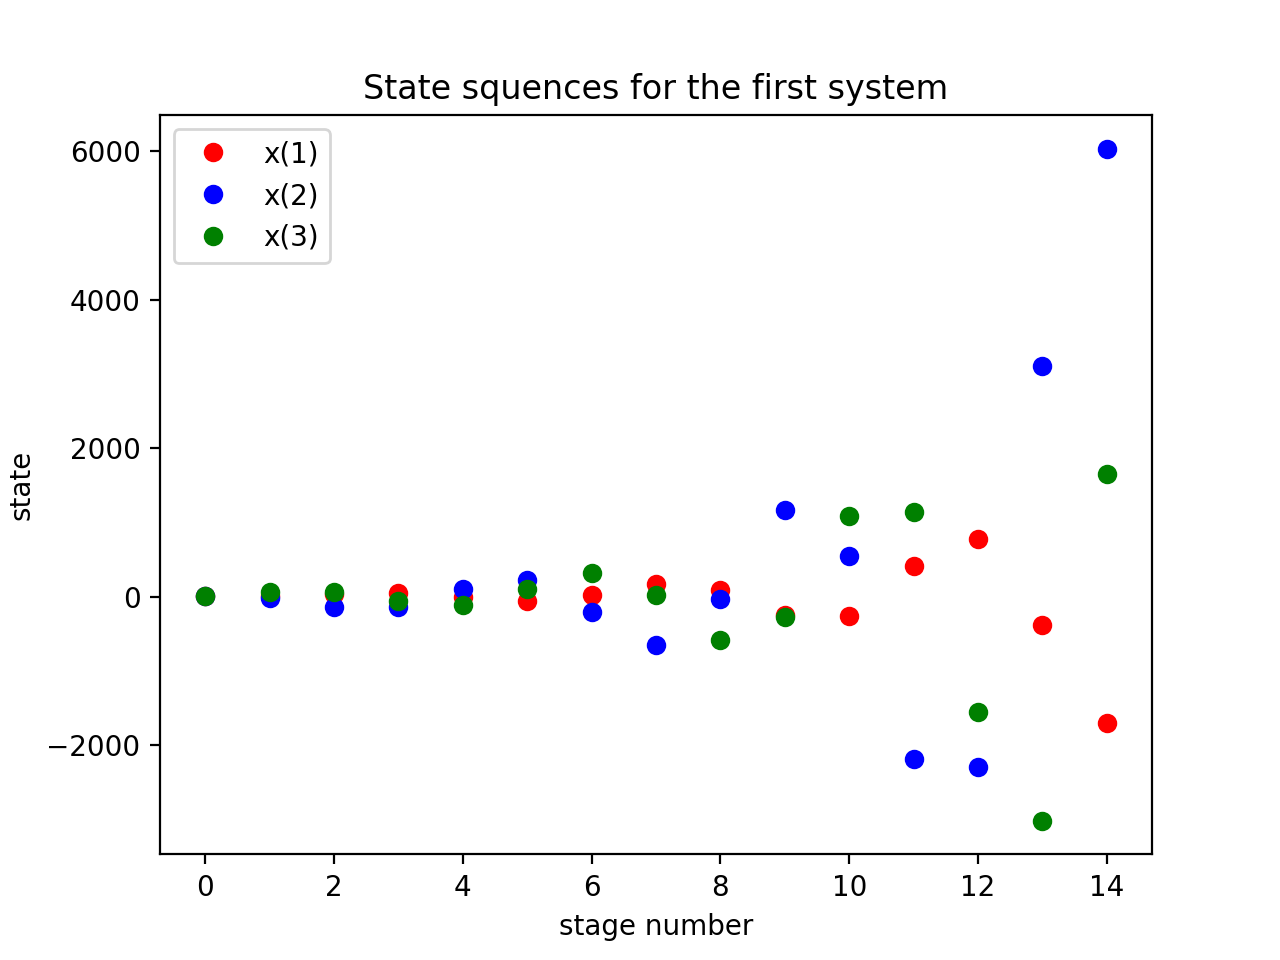

In [32]:
T=15
x=np.array([10,10,10])
state1=state_seq(x,A1,T)
state2=state_seq(x,A2,T)
state3=state_seq(x,A3,T)
horizon = np.linspace(0,T-1,T)
# state sequence plot
plt.figure()
plt.title('State squences for the first system')
plt.xlabel('stage number')
plt.ylabel('state')
plt.plot(horizon,state1[0,:],'ro',label="x(1)")
plt.plot(horizon,state1[1,:],'bo',label="x(2)")
plt.plot(horizon,state1[2,:],'go',label="x(3)")
plt.legend(loc="upper left")
plt.savefig('uncon_1.pdf') 

<IPython.core.display.Javascript object>


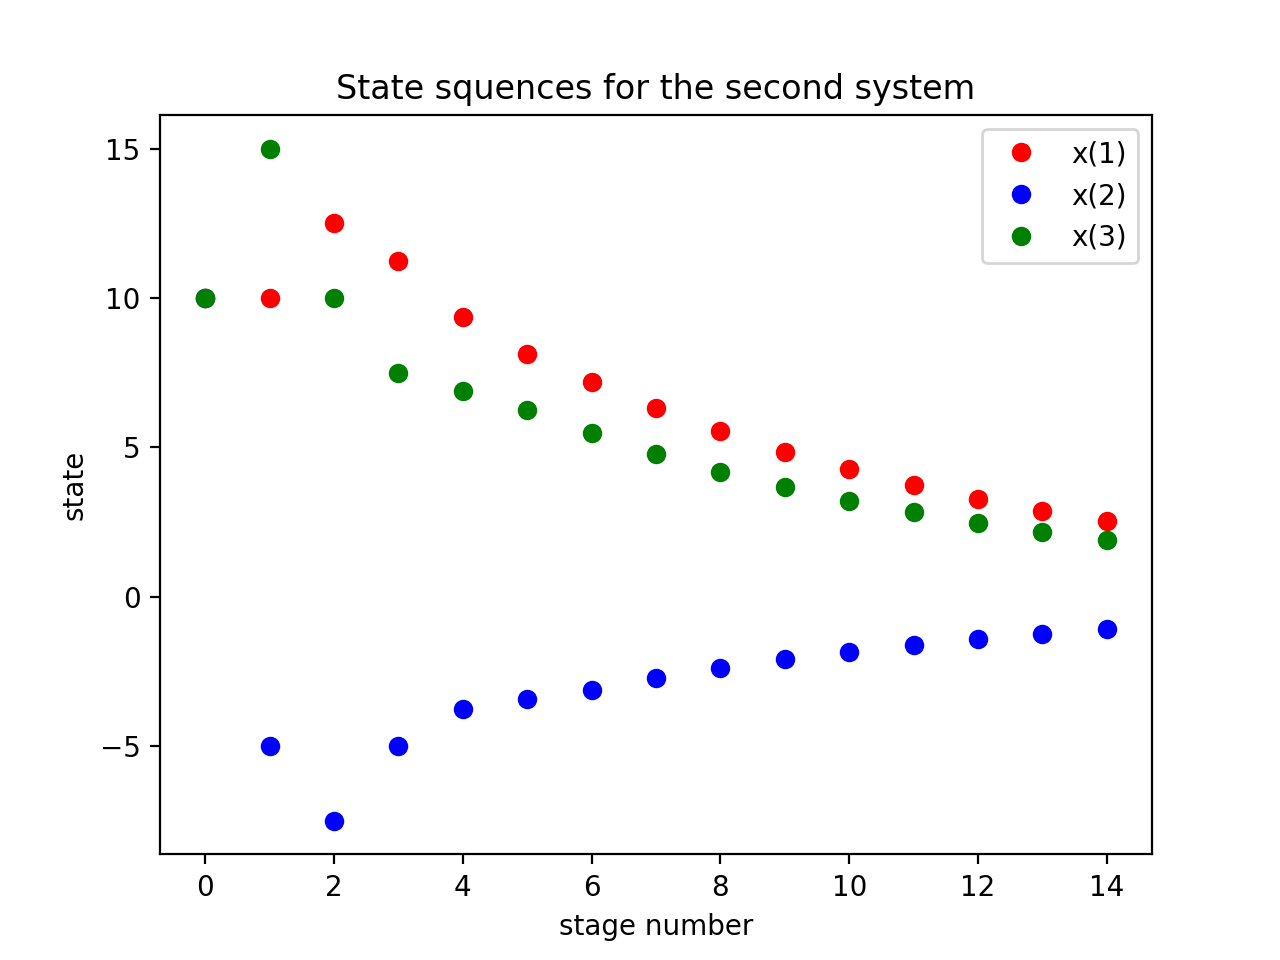

In [33]:
# state sequence plot
plt.figure()
plt.title('State squences for the second system')
plt.xlabel('stage number')
plt.ylabel('state')
plt.plot(horizon,state2[0,:],'ro',label="x(1)")
plt.plot(horizon,state2[1,:],'bo',label="x(2)")
plt.plot(horizon,state2[2,:],'go',label="x(3)")
plt.legend(loc="upper right")
plt.savefig('uncon_2.pdf') 

<IPython.core.display.Javascript object>


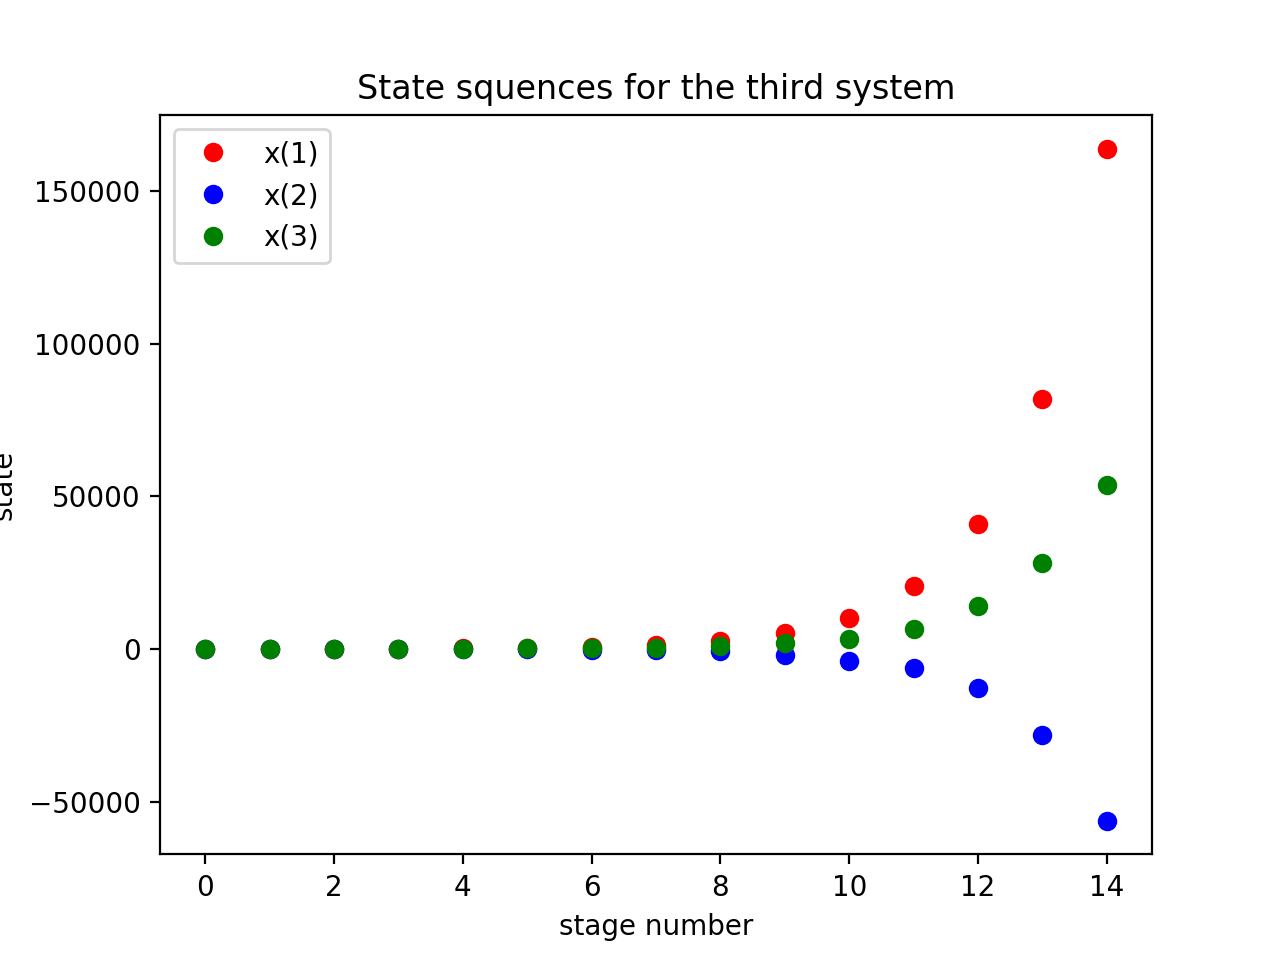

In [34]:
# state sequence plot
plt.figure()
plt.title('State squences for the third system')
plt.xlabel('stage number')
plt.ylabel('state')
plt.plot(horizon,state3[0,:],'ro',label="x(1)")
plt.plot(horizon,state3[1,:],'bo',label="x(2)")
plt.plot(horizon,state3[2,:],'go',label="x(3)")
plt.legend(loc="upper left")
plt.savefig('uncon_3.pdf') 

In [35]:
# compute the linear control for infinite LQR
#A, B, Q, R are matrices involved; tol: tolerance; maxit: maximum iteration number
def inf_lqr(A,B,Q,R,tol,maxit):
    e=1
    dim1=np.size(A,1)
    dim2=np.size(B,1)
    #initialization
    K=np.zeros((dim2,dim1))
    P=np.eye(dim1)
    count=0
    while count<maxit:
        # ricatti equation
        P=Q+A.T.dot(P).dot(A)+A.T.dot(P).dot(B).dot(K)
        m=B.T.dot(P).dot(B)+R
        K1=-np.linalg.solve(m,B.T.dot(P).dot(A))
        e=np.linalg.norm(K1-K)
        # if the differnce is below the tol
        if e<tol:
            break
        count=count+1
        K=K1
    return K

In [36]:
# the optimal gain is given by
Q=100*np.eye(3)
R=np.eye(2)
inf_lqr(A1,B,Q,R,1e-3,1000)

array([[-0.03675, -0.00031,  1.94465],
       [-4.11118, -1.98581, -1.13216]])

In [37]:
def state_seq_LQR(x,A,B,Q,R,T):
    state_seq = np.empty([3,T])
    ctrl_seq = np.empty([2,T])
    K=inf_lqr(A,B,Q,R,tol=1e-3,maxit=1000)
    for t in range(T):
        state_seq[:,t]=x
        u=K.dot(x)
        ctrl_seq[:,t]=u
        x = A.dot(x)+B.dot(u)
    return state_seq, ctrl_seq

<IPython.core.display.Javascript object>


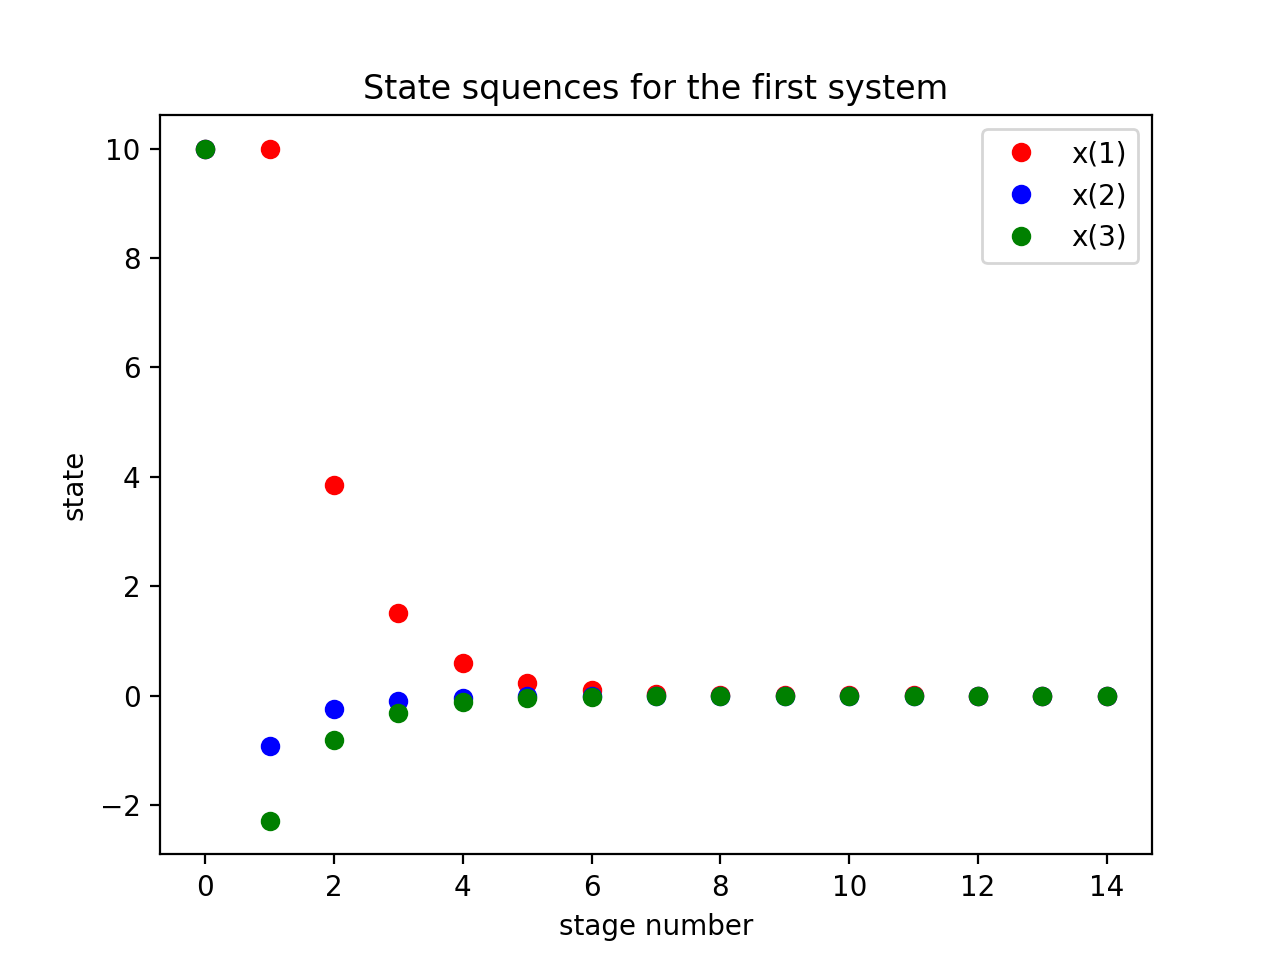

In [38]:
# LQR simulation
T=15
x=np.array([10,10,10])
state_lqr1, ctrl1=state_seq_LQR(x,A1,B,Q,R,T)
state_lqr2, ctrl2=state_seq_LQR(x,A2,B,Q,R,T)
state_lqr3, ctrl3=state_seq_LQR(x,A3,B,Q,R,T)
horizon = np.linspace(0,T-1,T)
# state sequence plot
plt.figure()
plt.title('State squences for the first system')
plt.xlabel('stage number')
plt.ylabel('state')
plt.plot(horizon,state_lqr1[0,:],'ro', label="x(1)")
plt.plot(horizon,state_lqr1[1,:],'bo', label="x(2)")
plt.plot(horizon,state_lqr1[2,:],'go', label="x(3)")
plt.legend(loc="upper right")
plt.savefig('con_1.pdf') 

<IPython.core.display.Javascript object>


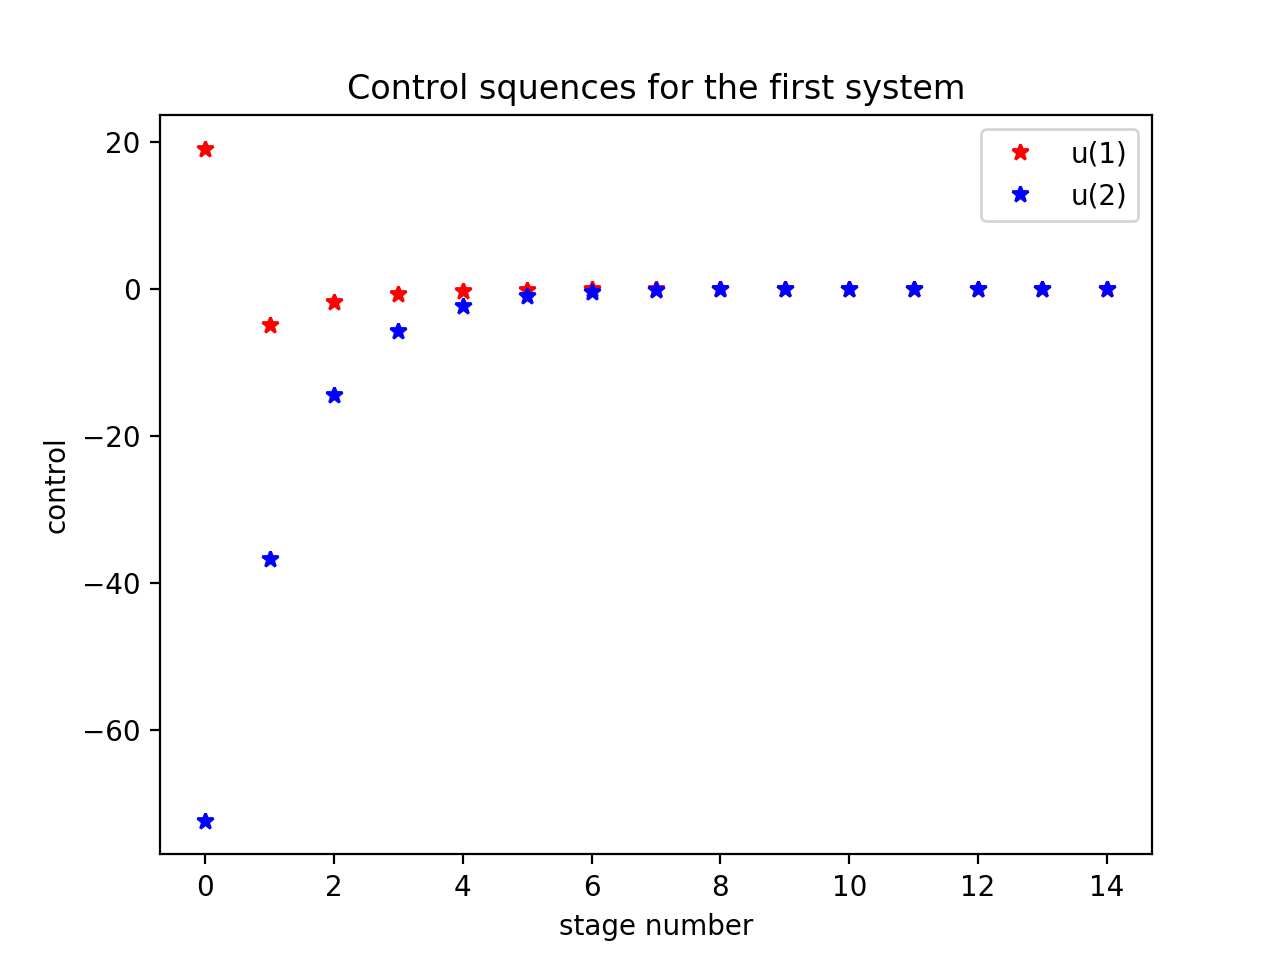

In [39]:
# control sequence plot
plt.figure()
plt.title('Control squences for the first system')
plt.xlabel('stage number')
plt.ylabel('control')
plt.plot(horizon,ctrl1[0,:],'r*', label="u(1)")
plt.plot(horizon,ctrl1[1,:],'b*', label="u(2)")
plt.legend(loc="upper right")
plt.savefig('con_ctrl1.pdf') 

<IPython.core.display.Javascript object>


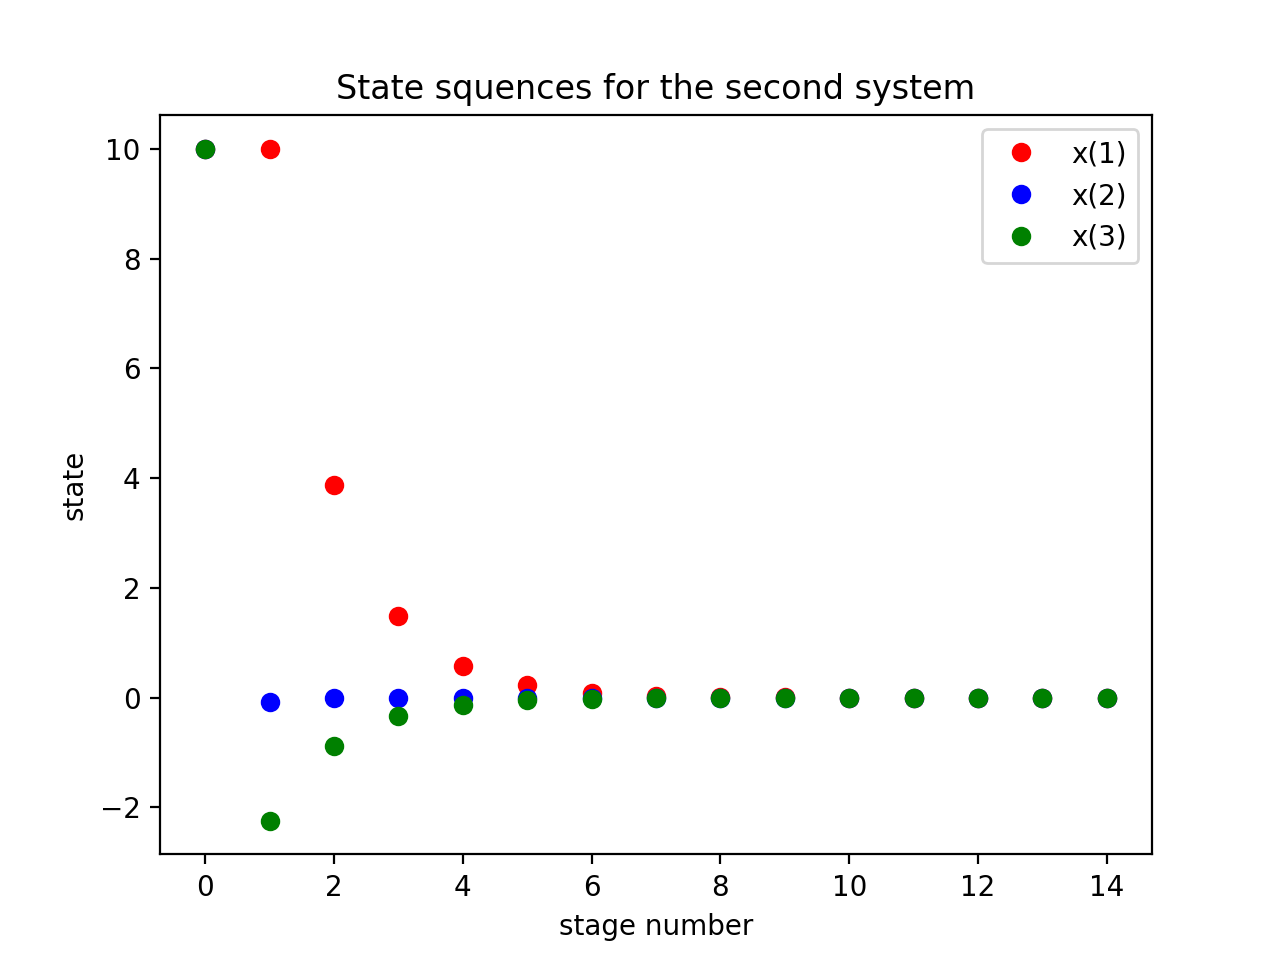

In [40]:
plt.figure()
plt.title('State squences for the second system')
plt.xlabel('stage number')
plt.ylabel('state')
plt.plot(horizon,state_lqr2[0,:],'ro', label="x(1)")
plt.plot(horizon,state_lqr2[1,:],'bo', label="x(2)")
plt.plot(horizon,state_lqr2[2,:],'go', label="x(3)")
plt.legend(loc="upper right")
plt.savefig('con_2.pdf') 

<IPython.core.display.Javascript object>


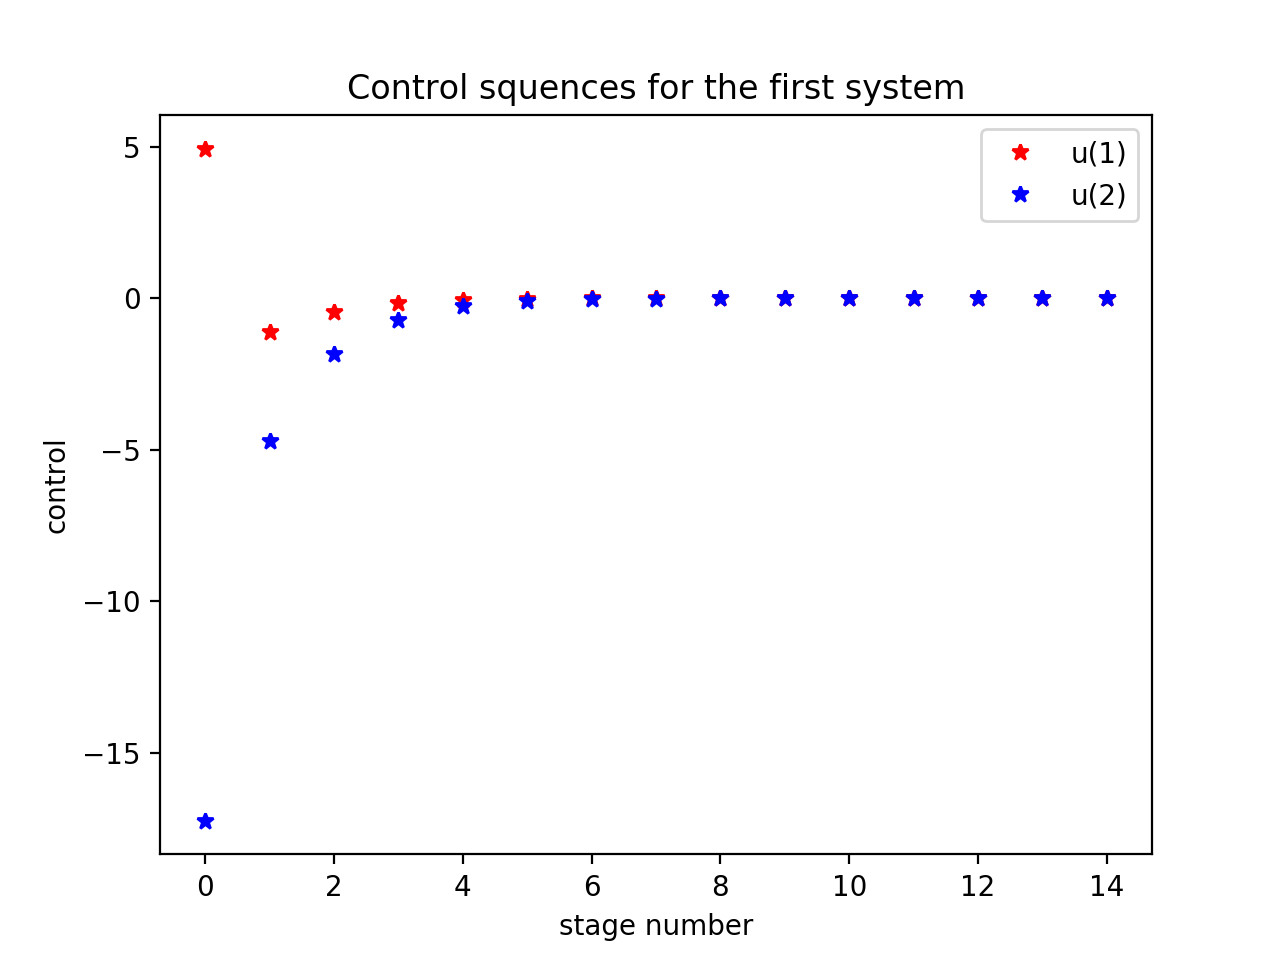

In [41]:
# control sequence plot
plt.figure()
plt.title('Control squences for the first system')
plt.xlabel('stage number')
plt.ylabel('control')
plt.plot(horizon,ctrl2[0,:],'r*', label="u(1)")
plt.plot(horizon,ctrl2[1,:],'b*', label="u(2)")
plt.legend(loc="upper right")
plt.savefig('con_ctrl2.pdf') 


<IPython.core.display.Javascript object>


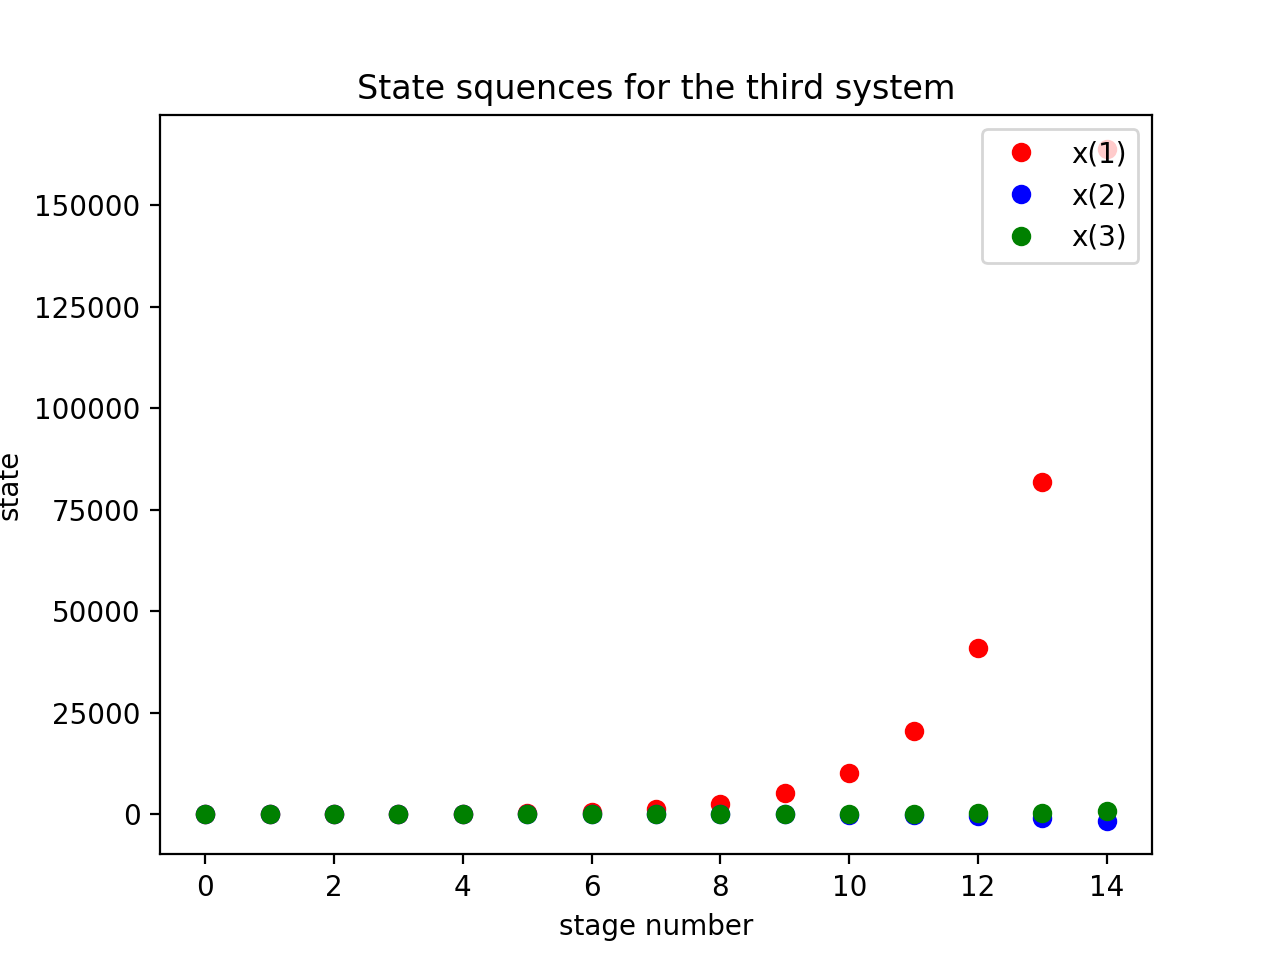

In [42]:
plt.figure()
plt.title('State squences for the third system')
plt.xlabel('stage number')
plt.ylabel('state')
plt.plot(horizon,state_lqr3[0,:],'ro', label="x(1)")
plt.plot(horizon,state_lqr3[1,:],'bo', label="x(2)")
plt.plot(horizon,state_lqr3[2,:],'go', label="x(3)")
plt.legend(loc="upper right")
plt.savefig('con_3.pdf') 

<IPython.core.display.Javascript object>


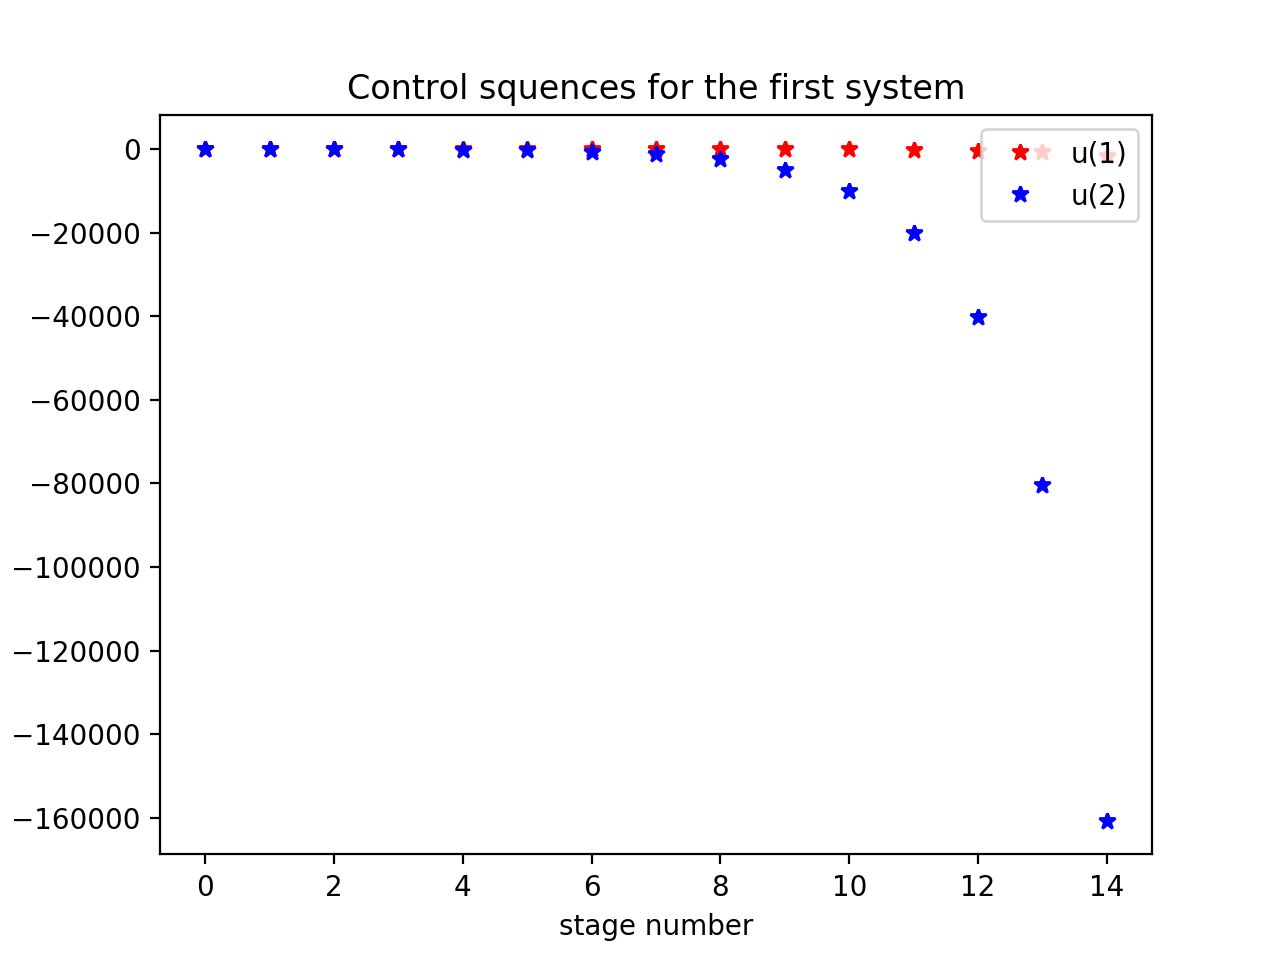

In [43]:
# control sequence plot
plt.figure()
plt.title('Control squences for the first system')
plt.xlabel('stage number')
plt.ylabel('control')
plt.plot(horizon,ctrl3[0,:],'r*', label="u(1)")
plt.plot(horizon,ctrl3[1,:],'b*', label="u(2)")
plt.legend(loc="upper right")
plt.savefig('con_ctrl3.pdf') 